<div align="center">

# Solar Flare Detection and Analysis System

### Asymmetric and Overlapping Flare Decomposition for GOES-16 X-Ray Flux Data

[![Python](https://img.shields.io/badge/Python-3.8%2B-blue?style=flat&logo=python&logoColor=white)](https://www.python.org/)
[![NumPy](https://img.shields.io/badge/NumPy-013243?style=flat&logo=numpy&logoColor=white)](https://numpy.org/)
[![Pandas](https://img.shields.io/badge/Pandas-150458?style=flat&logo=pandas&logoColor=white)](https://pandas.pydata.org/)
[![Matplotlib](https://img.shields.io/badge/Matplotlib-11557c?style=flat)](https://matplotlib.org/)
[![SciPy](https://img.shields.io/badge/SciPy-8CAAE6?style=flat&logo=scipy&logoColor=white)](https://scipy.org/)

</div>

---

<div align="center">

## Project Information

| Field | Details |
|-------|---------|
| **Project Title** | Solar Flare Detection , Decomposition and Analysis using GOES-16 X-Ray Sensor Data |
| **Author** | Pretam Das, Azad Tamim |
| **Supervisor** | Dr. Courtney Peck, Dr. Shah Mohammed Bahauddin |
| **Institution** | University of Chittagong |
| **Department** | Department of Physics x Department of Mathematics |
| **Date** | December 19, 2025 |
| **Version** | 1.0 |
| **Repository** | [Asymetric_Flare_Decomposition](https://github.com/pretamdas007/Asymmetric_Flare_Decompition) |

</div>

---

## Project Overview

This notebook implements an advanced flare decomposition technique for analyzing GOES-16 X-Ray Sensor (XRS) data. The methodology employs an **asymmetric model** that combines a Gaussian rise phase with an exponential decay, accurately capturing the physical characteristics of solar flare temporal profiles.

### Mathematical Model

The flare temporal profile is modeled using a piecewise function that accounts for the asymmetric nature of solar flare evolution:

$$
f(t) = 
\begin{cases}
A \cdot \exp\left(-\frac{(t - t_0)^2}{2\sigma_r^2}\right) & \text{for } t < t_0 \quad \text{(Gaussian rise)} \\[10pt]
A \cdot \exp\left(-\frac{t - t_0}{\tau_d}\right) & \text{for } t \geq t_0 \quad \text{(Exponential decay)}
\end{cases}
$$

**where:**

- $A$ : Peak amplitude of the flare (maximum X-ray flux in W/m²)
- $t_0$ : Time of maximum flux (peak time)
- $\sigma_r$ : Rise time scale parameter (controls the width of the Gaussian rise phase)
- $\tau_d$ : Decay time constant (e-folding time for exponential decay)
- $t$ : Time variable

### Physical Interpretation

**Rise Phase ($t < t_0$):** The Gaussian profile models the gradual energy release and heating of the solar plasma as magnetic reconnection initiates and accelerates. The rise time scale $\sigma_r$ characterizes the impulsiveness of the flare onset.

**Decay Phase ($t \geq t_0$):** The exponential decay reflects the cooling of the heated plasma through radiative and conductive losses. The decay constant $\tau_d$ is related to the characteristic cooling timescale of the flare-heated coronal loops.



---

## Data Source

**Satellite:** GOES-16 (Geostationary Operational Environmental Satellite)  
**Instrument:** XRS (X-Ray Sensor)  
**Coverage:** Continuous monitoring since 2017 to 2025 
**Spatial Resolution:** Full-disk solar observations  
**Temporal Resolution:** 1-minute cadence  
**Spectral Channels:**
- XRS-A: 0.5-4 Ångström (short wavelength)
- XRS-B: 1-8 Ångström (long wavelength)

**Official Data Repository:**  
[NOAA NCEI GOES-16 Archive](https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-avg1m_science/)

---

## Usage Instructions
### set `ENABLE_AUTO_OPTIMIZATION=False` or,
  **Configuration**: Set analysis parameters in the configuration section
   - Choose preset or custom configuration
   - Enable/disable auto-optimization
   - Set channel-specific parameters

---

## Acknowledgments

This work utilizes data from the GOES-16 satellite, operated by NOAA . Special thanks to the NOAA National Centers for Environmental Information (NCEI) for providing open access to satellite data.

---

<div align="center">

**© 2025 | Solar Flare Analysis Project**


</div>

### Imports
`pip install numpy,pandas,matplotlib,seaborn,scipy,joblib,netCDF4,multiprocessing,pybaselines`

In [551]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # for colormap generation
import matplotlib.dates as mdates # for handling dates in plots
import seaborn as sns # for data visualization
from scipy import signal # for signal processing and detect peaks
from scipy.optimize import curve_fit, differential_evolution # for optimization
from scipy.ndimage import gaussian_filter1d # for smoothing data
import multiprocessing
from joblib import Parallel, delayed # for parallel processing
from datetime import datetime, timedelta # for date and time manipulation
import netCDF4 as nc # 
from pybaselines import Baseline #
import warnings
warnings.filterwarnings("ignore")

### load Goes16 netCDF Download from here : https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-avg1m_science/

In [552]:
# Load GOES XRS NetCDF file
nc_file_path = r'E:\env_py\goesflareenv\main\solar_flare_analysis\data\sci_xrsf-l2-avg1m_g16_y2023_v2-2-0.nc'
dataset = nc.Dataset(nc_file_path, 'r') # Open NetCDF file # 'r' for read-only 

# Extract variables: time (seconds since J2000 epoch) and X-ray flux channels
time = dataset.variables['time'][:]
xrsa_flux = dataset.variables['xrsa_flux_observed'][:]  # 0.05-0.4 nm (short wavelength)
xrsb_flux = dataset.variables['xrsb_flux_observed'][:]  # 0.1-0.8 nm (long wavelength)

# Convert time to datetime objects (J2000 epoch: January 1, 2000 at 12:00 TT)
time_base = datetime(2000, 1, 1, 12, 0, 0)
time_datetime = [time_base + timedelta(seconds=float(t)) for t in time]

# Create DataFrame and close dataset
df = pd.DataFrame({'datetime': time_datetime, 'xrsa_flux': xrsa_flux, 'xrsb_flux': xrsb_flux})
dataset.close()

### Or, Download GOES XRS data in netCDF format from website, then open it with NASA's PANOPLY software.Here: https://www.giss.nasa.gov/tools/panoply/

Using PANOPLY you can convert .nc file to .csv file. From there only get those file flaged as (e.g. xrsa_flux_observed) without electron contamination .

### Load Goes csv , you can can find the converted csv here : https://github.com/pretamdas007/GOES-XRS16-csv
Change the data_path variable with your actual data path .    
Uncomment if you have csv file

In [553]:
"""
# Load the CSV data
data_path = 'data/2023_xrsa_xrsb.csv' # Update with your actual path
df = pd.read_csv(data_path)

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}") # Display column names
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum()) # Check for missing values
"""

'\n# Load the CSV data\ndata_path = \'data/2023_xrsa_xrsb.csv\' # Update with your actual path\ndf = pd.read_csv(data_path)\n\nprint(f"Original dataset shape: {df.shape}")\nprint(f"Columns: {df.columns.tolist()}") # Display column names\nprint("\nFirst few rows:")\nprint(df.head())\n\n# Check for missing values\nprint("\nMissing values:")\nprint(df.isnull().sum()) # Check for missing values\n'

### Preprocessing 

In [554]:
# Remove missing values
df_clean = df.dropna()
print(f"Dataset shape after cleaning: {df_clean.shape}")
# Filter data by time range (6-hour window)
start_datetime = '2023-01-02 10:45:00'
end_datetime = '2023-01-02 12:59:00'
df_truncated = df_clean[(df_clean['datetime'] >= start_datetime) & (df_clean['datetime'] <= end_datetime)].copy()
print(f"Truncated dataset shape: {df_truncated.shape}")
print(f"Time range: {df_truncated['datetime'].min()} to {df_truncated['datetime'].max()}")

Dataset shape after cleaning: (509419, 3)
Truncated dataset shape: (135, 3)
Time range: 2023-01-02 10:45:00 to 2023-01-02 12:59:00


### Converting Logs(For increasing the visibility of overlapping sub-peak )

In [555]:
# Extract data arrays
time_datetime = df_truncated['datetime'].values
xrsa_flux = df_truncated['xrsa_flux'].values
xrsb_flux = df_truncated['xrsb_flux'].values

# Create numeric time array for fitting algorithms
time_numeric = np.arange(len(time_datetime), dtype=np.float64)

# Calculate log10 values (avoid log(0) with epsilon)
epsilon = 1e-12
log_xrsa = np.log10(np.maximum(xrsa_flux, epsilon))
log_xrsb = np.log10(np.maximum(xrsb_flux, epsilon))


### Visualization Configuration (for great visuals)

In [556]:
def apply_plot_styling(ax, legend_loc='upper right', legend_fontsize=11, tick_rotation=45):
    """Apply consistent styling to matplotlib axes"""
    legend = ax.legend(loc=legend_loc, frameon=True, fancybox=True, shadow=True, framealpha=0.95, fontsize=legend_fontsize)
    legend.get_frame().set_facecolor('#2c2626')
    legend.get_frame().set_edgecolor('#bdc3c7')
    [text.set_color('white') for text in legend.get_texts()]
    
    [ax.spines[s].set_color('#bdc3c7') or ax.spines[s].set_linewidth(1.2) for s in ['top', 'right', 'bottom', 'left']]
    ax.tick_params(colors='white', which='both', labelsize=10, length=6, width=1.2, axis='x', rotation=tick_rotation)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M:%S'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

BASE_COMP_COLORS = ['#00F5FF', '#FF6B9D', '#FFA500', '#39FF14', '#C77DFF', '#00E5FF', '#FF69B4', '#7DF9FF', '#FFD700', '#00FFA3']

def get_component_colors(n_components):
    """Generate colors for any number of components"""
    if n_components <= len(BASE_COMP_COLORS):
        return BASE_COMP_COLORS[:n_components]
    colors = BASE_COMP_COLORS.copy()
    extra = cm.rainbow(np.linspace(0, 1, n_components - len(BASE_COMP_COLORS)))
    colors.extend(['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)) for r, g, b, _ in extra])
    return colors

VIZ_COLORS = {
    'simple': {'xrsa_main': "#d53321", 'xrsa_fill': "#fc8f85", 'xrsb_main': '#2980b9', 
               'xrsb_fill': "#79c0f2", 'grid': '#ecf0f1', 'background': "#3a3333"},
    'baseline': {'original': "#2079B4", 'baseline': '#E74C3C', 'corrected': "#94A5FD", 
                 'background': "#413939", 'text': "#BCC4CB", 'grid': '#ECF0F1'},
    'enhanced': {'data': "#0099FF", 'peak_marker': '#FF3366', 'comp_colors': BASE_COMP_COLORS, 
                 'total_fit': '#FF00FF', 'background': '#1a1a1a', 'grid': '#404040', 'text': '#FFFFFF'}
}

COLORS = VIZ_COLORS['enhanced']  # Backward compatibility


### Visualize the Log(flux) vs Time 

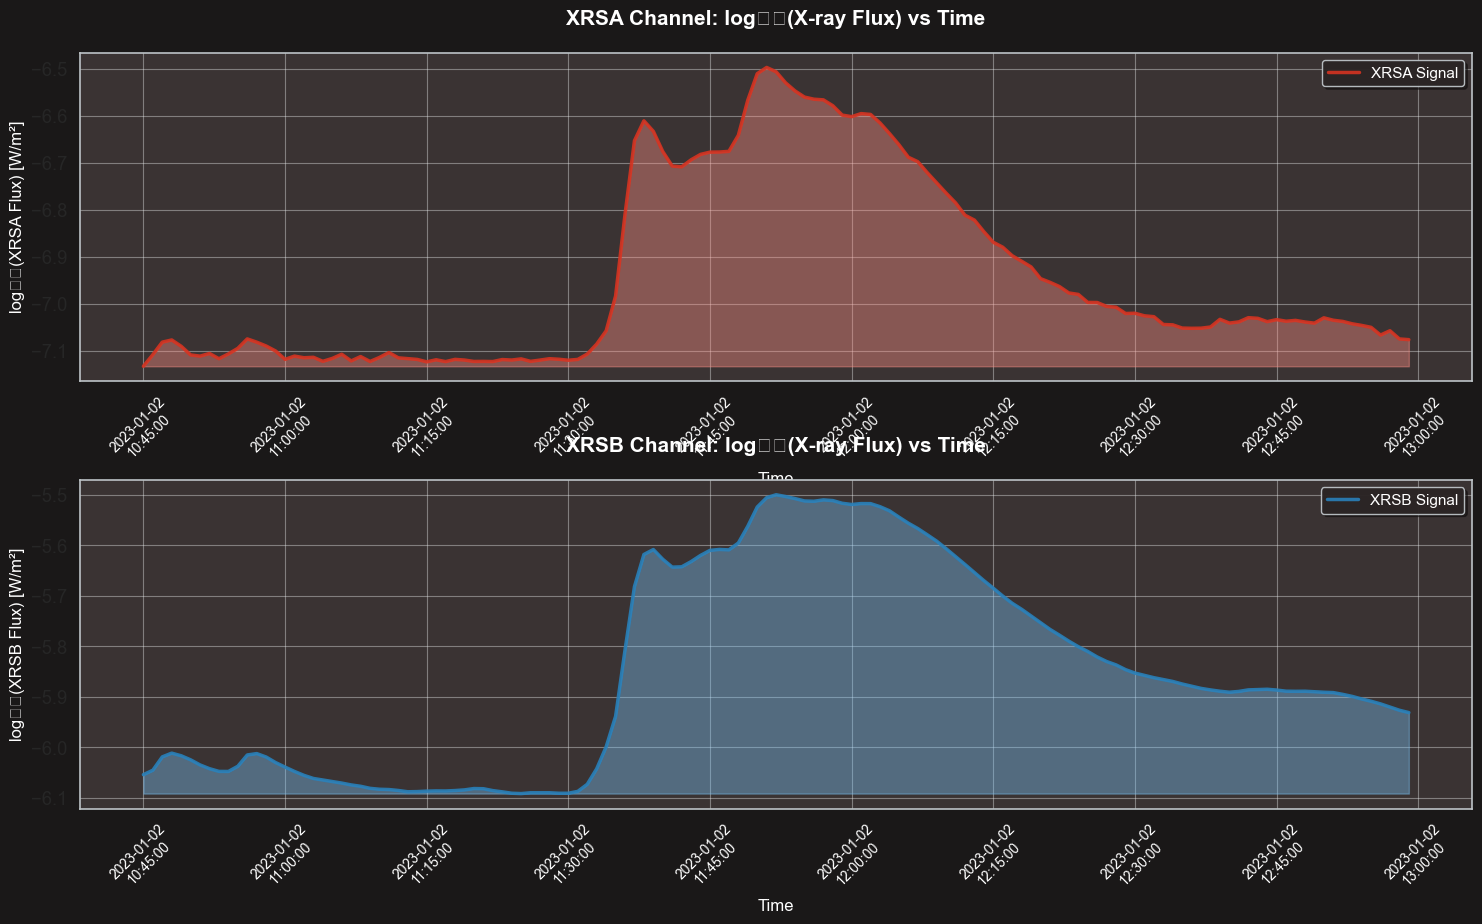

In [557]:
fig, axes = plt.subplots(2, 1, figsize=(16, 9))
fig.patch.set_facecolor("#1a1818")
colors = VIZ_COLORS['simple']

# Configure channels
channels = [
    ('XRSA', log_xrsa, colors['xrsa_main'], colors['xrsa_fill']),
    ('XRSB', log_xrsb, colors['xrsb_main'], colors['xrsb_fill'])
]

for ax, (name, data, main_color, fill_color) in zip(axes, channels):
    ax.set_facecolor(colors['background'])
    
    if len(time_datetime) > 0 and len(data) > 0:
        ax.plot(time_datetime, data, color=main_color, linewidth=2.5, alpha=0.9, label=f'{name} Signal')
        ax.fill_between(time_datetime, data, np.min(data), color=fill_color, alpha=0.4)
    else:
        ax.text(0.5, 0.5, f'No {name} data available', transform=ax.transAxes, 
                ha='center', va='center', color='white', fontsize=12)
    
    ax.set_title(f'{name} Channel: log₁₀(X-ray Flux) vs Time', fontsize=15, fontweight='bold', color='white', pad=20)
    ax.set_ylabel(f'log₁₀({name} Flux) [W/m²]', fontsize=12, color='white')
    ax.set_xlabel('Time', fontsize=12, color='white')
    ax.grid(True, alpha=0.4, color=colors['grid'], linewidth=0.8)
    apply_plot_styling(ax)

plt.subplots_adjust(hspace=0.3, left=0.08, right=0.95, top=0.92, bottom=0.08)
plt.show()

### Baseline Correction 
 ASLS(Asymmetric Least Squares baseline correction.) is designed to estimate a smooth baseline from a signal that contains positive peaks (e.g., Raman, IR, XRD). Peaks distort simple polynomial fitting, so ASLS uses asymmetric weighting to reduce the effect of peaks.
### Tweaking lam and p allows fine control over smoothness and peak suppression.

In [558]:
# Apply AsLS baseline correction (λ=smoothing, p=asymmetry)
baseline_fitter = Baseline(time_datetime)

# XRSA baseline correction
xrsa_baseline = baseline_fitter.asls(log_xrsa, lam=1e4, p=0.001)[0]
xrsa_corrected = log_xrsa - xrsa_baseline

# XRSB baseline correction
xrsb_baseline = baseline_fitter.asls(log_xrsb, lam=1e4, p=0.001)[0]
xrsb_corrected = log_xrsb - xrsb_baseline

### Baseline correction visualization 

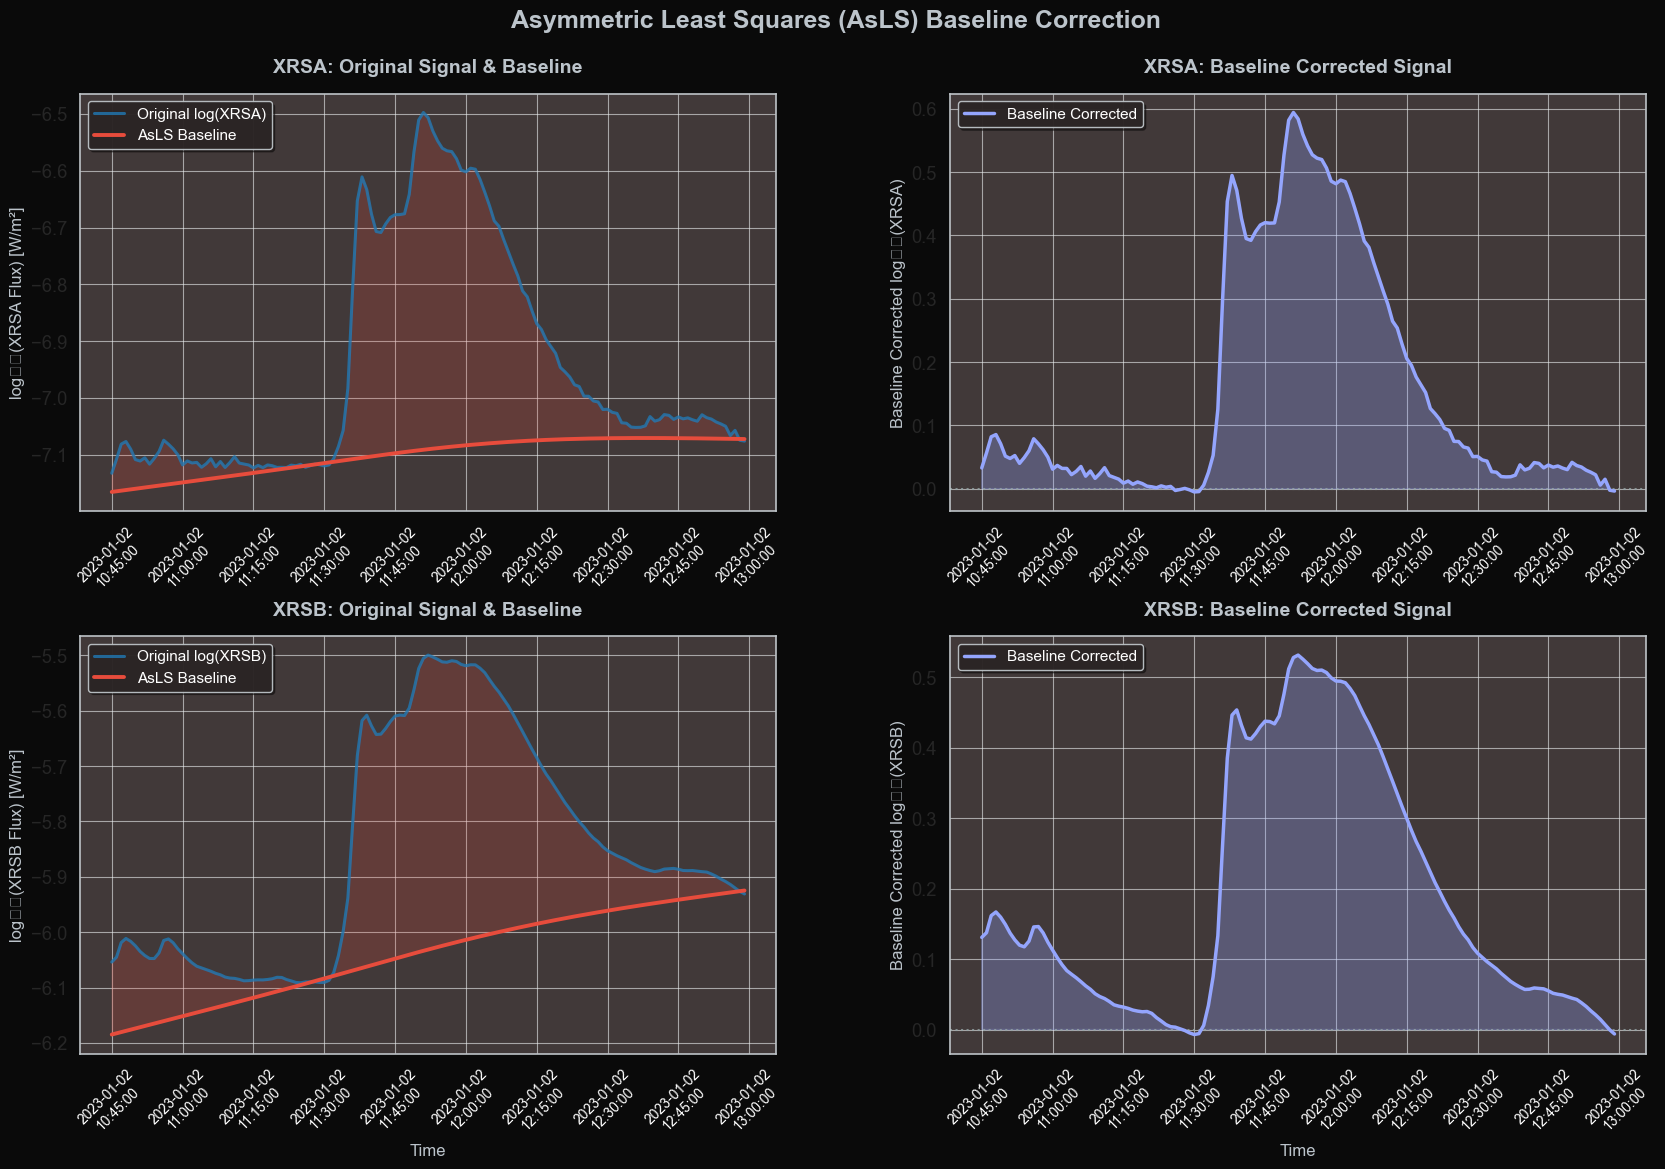

In [559]:
plt.rcdefaults()
sns.set_style("darkgrid", {"axes.facecolor": "#2b2727", "grid.color": "#e0e0e0"})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
colors = VIZ_COLORS['baseline']

fig = plt.figure(figsize=(18, 12))
fig.patch.set_facecolor('#0a0a0a')
fig.suptitle('Asymmetric Least Squares (AsLS) Baseline Correction', fontsize=18, 
             fontweight='bold', color=colors['text'], y=0.95)
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.25, left=0.08, right=0.95, top=0.88, bottom=0.08)

# Channel configurations: (name, log_data, baseline, corrected, row)
channels = [('XRSA', log_xrsa, xrsa_baseline, xrsa_corrected, 0),
            ('XRSB', log_xrsb, xrsb_baseline, xrsb_corrected, 1)]

for name, log_data, baseline, corrected, row in channels:
    # Original with baseline
    ax = fig.add_subplot(gs[row, 0])
    ax.set_facecolor(colors['background'])
    ax.plot(time_datetime, log_data, color=colors['original'], linewidth=2.2, alpha=0.8, label=f'Original log({name})', zorder=3)
    ax.plot(time_datetime, baseline, color=colors['baseline'], linewidth=2.8, label='AsLS Baseline', zorder=4)
    ax.fill_between(time_datetime, log_data, baseline, alpha=0.2, color=colors['baseline'], zorder=1)
    ax.set_title(f'{name}: Original Signal & Baseline', fontsize=14, fontweight='bold', color=colors['text'], pad=15)
    ax.set_ylabel(f'log₁₀({name} Flux) [W/m²]', fontsize=12, color=colors['text'])
    if row == 1: ax.set_xlabel('Time', fontsize=12, color=colors['text'])
    ax.grid(True, alpha=0.6, color=colors['grid'], linewidth=0.8)
    apply_plot_styling(ax, legend_loc='upper left')
    
    # Corrected signal
    ax = fig.add_subplot(gs[row, 1])
    ax.set_facecolor(colors['background'])
    ax.plot(time_datetime, corrected, color=colors['corrected'], linewidth=2.5, label='Baseline Corrected', zorder=3)
    ax.axhline(y=0, color='#95A5A6', linestyle=':', alpha=0.8, linewidth=1.5, zorder=2)
    ax.fill_between(time_datetime, 0, corrected, where=corrected >= 0, alpha=0.3, color=colors['corrected'], interpolate=True, zorder=1)
    ax.set_title(f'{name}: Baseline Corrected Signal', fontsize=14, fontweight='bold', color=colors['text'], pad=15)
    ax.set_ylabel(f'Baseline Corrected log₁₀({name})', fontsize=12, color=colors['text'])
    if row == 1: ax.set_xlabel('Time', fontsize=12, color=colors['text'])
    ax.grid(True, alpha=0.6, color=colors['grid'], linewidth=0.8)
    apply_plot_styling(ax, legend_loc='upper left')

plt.show()

## Configuration & Parameter Optimization

**Select a preset configuration or customize manually:**

| Preset | Description | Configuration |
|--------|-------------|--------------|
| **1. Manual Mode** (Recommended) | Full control over detection parameters | `ENABLE_AUTO_OPTIMIZATION = False` |
| **2. Auto-Optimize** | Balanced approach for general use | `ENABLE_AUTO_OPTIMIZATION = True`<br>`OPTIMIZATION_STRATEGY = 'adaptive'`<br>`OPTIMIZATION_ITERATIONS = 20`<br>`OPTIMIZATION_OBJECTIVE = 'balanced'` |
| **3. Maximum Sensitivity** | Detect all possible sub-peaks | `ENABLE_AUTO_OPTIMIZATION = True`<br>`OPTIMIZATION_OBJECTIVE = 'max_peaks'`<br>`OPTIMIZATION_ITERATIONS = 30` |
| **4. Best Fit Quality** | Prioritize accuracy over peak count | `ENABLE_AUTO_OPTIMIZATION = True`<br>`OPTIMIZATION_OBJECTIVE = 'best_fit'`<br>`OPTIMIZATION_ITERATIONS = 25` |

### 1. Optimization Settings 
`ENABLE_AUTO_OPTIMIZATION=False` : if you want to place custom value in detection parameter

In [560]:
# Enable this to automatically find optimal parameters for your data
ENABLE_AUTO_OPTIMIZATION = False  # ← Set to True to enable automatic parameter search

# Optimization strategy: 'grid' (exhaustive), 'adaptive' (smart search)
OPTIMIZATION_STRATEGY = 'adaptive'  # ← 'adaptive' recommended for balance of speed and accuracy

# Number of optimization iterations (higher = better but slower)
OPTIMIZATION_ITERATIONS = 20  # ← Range: 10 (fast), 20 (balanced), 50 (thorough)

# Optimization objective: 'max_peaks', 'best_fit', or 'balanced'
OPTIMIZATION_OBJECTIVE = 'balanced'  # ← 'balanced' recommended for most cases

#### 2. PARAMETER SEARCH RANGES (Used when AUTO_OPTIMIZATION is enabled)

In [561]:
# XRSA Parameter Ranges
XRSA_PARAM_RANGES = {
    'prominence_factor': (0.001, 0.5),      # Range for prominence sensitivity
    'min_peak_distance': (0.0001, 5.0),      # Range for peak spacing
    'min_height_factor': (0.0001, 0.01),     # Range for minimum peak height factor
    'analysis_window': (100, 150),            # Range for window size
    'peak_window_size': (20, 50),           # Range for individual peak window
    'n_components': (1, 15),                 # Range for number of components
    'min_r2_threshold': (0.01, 0.4),        # Range for R² threshold
    'r2_tolerance': (0.00001, 0.01)  }        # Range for R² tolerance


In [562]:
# XRSB Parameter Ranges
XRSB_PARAM_RANGES = {
    'prominence_factor': (0.001, 0.02),      # More sensitive range for XRSB
    'min_peak_distance': (0.0001, 5.0),      # Range for peak spacing
    'min_height_factor': (0.0001, 0.005),    # Range for minimum peak height factor (more sensitive)
    'analysis_window': (100, 150),            # Range for window size
    'peak_window_size': (20, 50),           # Range for individual peak window
    'n_components': (1, 15),                 # Range for number of components
    'min_r2_threshold': (0.1, 0.4),        # Range for R² threshold
    'r2_tolerance': (0.00001, 0.01) }         # Range for R² tolerance

#### 3. General Processing Settings (use parallel processing for faster calculations)

In [563]:
# Parallel processing configuration
N_JOBS = -1  # ← Number of CPUs to use (-1: all available, 1: no parallel, 2+: specific number)
PARALLEL_VERBOSE = 1  # ← Verbosity level (0: silent, 1: progress bar, 2+: detailed)

# Multi-peak fitting mode
FIT_ALL_PEAKS = True      # ← True: fit each detected peak separately
FITTING_METHOD = 'global'  # ← 'global' (slower, better) or 'local' (faster)
SELECTION_CRITERION = 'r2_prefer_more'  # ← 'aic', 'bic', 'r2', or 'r2_prefer_more'

### If the Auto optimization is not selected , manually change these parameter

#### 4. XRSA Channel Configuration

In [564]:
# Peak detection settings
XRSA_PROMINENCE_FACTOR = 0.01         # Sensitivity to peak prominence
XRSA_MIN_PEAK_DISTANCE = 0.01         # Minimum distance between peaks
XRSA_MIN_PEAK_HEIGHT_FACTOR = 0.001   # Minimum height threshold factor

# Window sizes
XRSA_ANALYSIS_WINDOW = 120            # Size of analysis window around main peak
XRSA_PEAK_WINDOW_SIZE = 60            # Size of window for individual peak fitting

# Fitting settings
XRSA_N_COMPONENTS = 8                # Number of components to fit
XRSA_FITTING_METHOD = 'global'        # Fitting method: 'global' or 'local'
XRSA_INDIVIDUAL_FIT_METHOD = 'global' # Method for individual peak fits

# Multi-peak fitting
XRSA_FIT_ALL_PEAKS = True             # Enable individual peak fitting
XRSA_MIN_R2_FOR_INDIVIDUAL = 0.02     # Minimum R² for individual fits

# Model selection
XRSA_SELECTION_CRITERION = 'r2_prefer_more'  # Model selection criterion
XRSA_MIN_R2_THRESHOLD = 0.010         # Minimum R² threshold
XRSA_R2_TOLERANCE = 0.00001           # R² tolerance for model selection
XRSA_AUTO_FIT = False                 # Enable automatic component number selection
XRSA_MAX_COMPONENTS = 6               # Maximum components when auto-fitting

#### 5. XRSB Channel Configuration(More Sensitive)

In [565]:
# Peak detection settings (more sensitive than XRSA)
XRSB_PROMINENCE_FACTOR = 0.005        # Higher sensitivity for sub-peak detection
XRSB_MIN_PEAK_DISTANCE = 0.0000001    # Very small minimum distance for close peaks
XRSB_MIN_PEAK_HEIGHT_FACTOR = 0.0000001  # Very low height threshold

# Window sizes
XRSB_ANALYSIS_WINDOW = 120            # Size of analysis window around main peak
XRSB_PEAK_WINDOW_SIZE = 60            # Size of window for individual peak fitting

# Fitting settings
XRSB_N_COMPONENTS = 8                # Number of components to fit
XRSB_FITTING_METHOD = 'global'        # Fitting method: 'global' or 'local'
XRSB_INDIVIDUAL_FIT_METHOD = 'global' # Method for individual peak fits

# Multi-peak fitting
XRSB_FIT_ALL_PEAKS = True             # Enable individual peak fitting
XRSB_MIN_R2_FOR_INDIVIDUAL = 0.02     # Minimum R² for individual fits

# Model selection
XRSB_SELECTION_CRITERION = 'r2_prefer_more'  # Model selection criterion
XRSB_MIN_R2_THRESHOLD = 0.010         # Minimum R² threshold
XRSB_R2_TOLERANCE = 0.000001          # Tighter R² tolerance than XRSA
XRSB_AUTO_FIT = False                 # Enable automatic component number selection
XRSB_MAX_COMPONENTS = 10              # Maximum components when auto-fitting

### 1. Flare Equation Function
#### `multi_asymmetric_flare(t, *params)`
  - Each set of 4 consecutive values: `(A, t0, sigma_r, tau_d)`
  - Total parameters = 4 × number_of_components

```
f_total(t) = Σ asymmetric_flare(t, A_i, t0_i, sigma_r_i, tau_d_i)
```

This allows fitting complex light curves with multiple overlapping flare events, each with independent parameters.

In [566]:
def asymmetric_flare(t, A, t0, sigma_r, tau_d):
    """Asymmetric flare model: Gaussian rise (t < t0) + Exponential decay (t >= t0)"""
    t = np.asarray(t, dtype=np.float64)
    result = np.zeros_like(t, dtype=np.float64)
    
    # Ensure positive parameters and prevent division by zero
    A, sigma_r, tau_d = np.abs(A), max(np.abs(sigma_r), 1e-10), max(np.abs(tau_d), 1e-10)
    # Gaussian rise phase
    mask_rise = t < t0
    if np.any(mask_rise):
        result[mask_rise] = A * np.exp(-((t[mask_rise] - t0)**2) / (2 * sigma_r**2))
    # Exponential decay phase
    mask_decay = t >= t0
    if np.any(mask_decay):
        result[mask_decay] = A * np.exp(-(t[mask_decay] - t0) / tau_d)
    
    return result

def multi_asymmetric_flare(t, *params): 
    """Sum of multiple asymmetric flare components (4 params per component: A, t0, sigma_r, tau_d)"""
    t = np.asarray(t, dtype=np.float64)
    n_components = len(params) // 4
    result = np.zeros_like(t, dtype=np.float64)
    for i in range(n_components):
        A, t0, sigma_r, tau_d = params[i*4:(i+1)*4] 
        result += asymmetric_flare(t, A, t0, sigma_r, tau_d)
    
    return result

### 2. Peak detection function (basically `scipy.signal.find_peaks` but some little changes on `min_distance` and `prominence_factor` )

In [567]:
def find_significant_peaks(data, time, prominence_factor=0.01, min_distance=0.01, min_height_factor=0.001):
    """Detect significant peaks using adaptive thresholding"""
    data = np.asarray(data, dtype=np.float64)
    valid_data = data[np.isfinite(data)] # Exclude NaNs/Infs
    
    # Calculate adaptive thresholds
    data_std, data_mean, data_max = np.std(valid_data), np.mean(valid_data), np.max(valid_data)
    prominence_threshold = prominence_factor * data_std  
    height_threshold = data_mean + min_height_factor * data_std 
    distance_param = None if min_distance < 1 else int(min_distance)
    
    # Find peaks
    if distance_param is not None:
        peaks, properties = signal.find_peaks(data, prominence=prominence_threshold,distance=distance_param, width=1, height=height_threshold)
    else:
        peaks, properties = signal.find_peaks(data, prominence=prominence_threshold, width=0.09, height=height_threshold)
    
    # Filter noise peaks (keep peaks > 0.001% of max)
    if len(peaks) > 0:
        significant_mask = data[peaks] > (data_max * 0.001)
        peaks = peaks[significant_mask]
        if len(peaks) > 0:
            print(f"   Peak heights: {data[peaks]}")
    
    return peaks, properties

def extract_peak_region(data, time, peak_idx, window_size=150):
    """Extract data region around peak with boundary handling"""
    data = np.asarray(data, dtype=np.float64)
    half_window = window_size // 2
    start_idx = max(0, peak_idx - half_window)
    end_idx = min(len(data), peak_idx + half_window)
    
    # Adjust window if near boundaries
    if start_idx == 0 and end_idx < window_size:
        end_idx = min(window_size, len(data))
        print(f" peak too close to start (shifted right)")
    elif end_idx == len(data) and (end_idx - start_idx) < window_size:
        start_idx = max(0, len(data) - window_size)
        print(f"peak too close to end (shifted left)")
    
    if (end_idx - start_idx) < window_size:
        print(f"  Warning: Insufficient data - got {end_idx - start_idx} points instead of {window_size}")
    
    return start_idx, end_idx

def extract_individual_peak_region(data, time, peak_idx, window_size=60):
    """Extract smaller region around individual peak"""
    data = np.asarray(data, dtype=np.float64)
    half_window = window_size // 2
    start_idx = max(0, peak_idx - half_window)
    end_idx = min(len(data), peak_idx + half_window)
    return start_idx, end_idx

### 3. Parameter Estimation: 

**1. Amplitude ($A$) and Peak Time ($t_0$)**
- Directly identified as the maximum value in the normalized signal
- No estimation needed—these are observables

**2. Rise Time ($\sigma_r$)**

Uses the **Full Width at Half Maximum (FWHM)** relationship for Gaussian distributions:

$$
\text{FWHM} = 2\sqrt{2\ln 2} \cdot \sigma_r \approx 2.355 \cdot \sigma_r
$$

The code finds where the rising signal reaches 50% of peak amplitude, calculates the half-width, then converts:

$$
\sigma_r = \frac{\text{half-width}}{1.177}
$$

where $1.177 \approx \sqrt{2\ln 2}$.

**3. Decay Time ($\tau_d$)**

For exponential decay, the time constant $\tau_d$ is the time for intensity to drop to $1/e \approx 36.8\%$ of the peak:

$$
I(t) = A \cdot e^{-(t-t_0)/\tau_d} \implies I(t_0 + \tau_d) = A/e
$$
The algorithm locates this $1/e$ point in the decay phase to estimate $\tau_d$.

Sub-components get progressively longer time constants:
- Rise time: $\sigma_{\text{sub}} = \sigma_{\text{main}} \times (1.0 + 0.2 \times n)$
- Decay time: $\tau_{\text{sub}} = \tau_{\text{main}} \times (1.2 + 0.25 \times n)$

This reflects the physical reality that overlapping flares often have varying durations.


In [568]:
def estimate_initial_params(x, y, n_components=1):
    x, y = np.asarray(x, dtype=np.float64), np.asarray(y, dtype=np.float64)
    y_normalized = y - np.min(y)
    peak_idx = np.argmax(y_normalized)
    amplitude, peak_time = y_normalized[peak_idx], x[peak_idx]
    time_range = x[-1] - x[0]
    min_time = time_range / 50
    
    rise_signal = y_normalized[:peak_idx]
    half_max_idx = np.where(rise_signal >= amplitude * 0.5)[0][0] # 50% of amplutude  
    rise_time = max((peak_time - x[half_max_idx]) / 1.177, min_time)
    
    decay_signal = y_normalized[peak_idx:]
    decay_times = x[peak_idx:]
    target = amplitude / np.e
    decay_point_idx = np.argmin(np.abs(decay_signal - target))
    tau = decay_times[decay_point_idx] - peak_time
    decay_time = max(tau if tau >= 0.01 else (x[-1] - peak_time) / 3, min_time)
    
    params = [amplitude, peak_time, rise_time, decay_time]
    
    if n_components == 1:
        return params
    
    y_smoothed = gaussian_filter1d(y_normalized, sigma=1)
    detected_peaks, _ = find_significant_peaks(y_smoothed, x, prominence_factor=0.05, min_distance=0.01, min_height_factor=0.01)
    min_separation = len(x) // 300 # for example, 0.33% of data length (to avoid close peaks but maintain the sensitivity)
    valid_peaks = detected_peaks[np.abs(detected_peaks - peak_idx) > min_separation]
    if len(valid_peaks) > 0:
        valid_peaks = valid_peaks[np.argsort(y_smoothed[valid_peaks])[::-1]] # sort by height descending
    
    for component_num in range(1, n_components):
        if (component_num - 1) < len(valid_peaks):
            peak_idx_sub = valid_peaks[component_num - 1]
            time_sub, amp_sub = x[peak_idx_sub], y_normalized[peak_idx_sub] * 0.8 
        
        rise_sub = rise_time * (1.0 + 0.2 * component_num)
        decay_sub = decay_time * (1.2 + 0.25 * component_num)
        params.extend([amp_sub, time_sub, rise_sub, decay_sub])
    
    return params

### 4. Calculates R^2 , AIC , BIC 

In [569]:
def calculate_quality_metrics(y_clean, y_pred_clean, popt):
    ss_res = np.sum((y_clean - y_pred_clean) ** 2)
    ss_tot = np.sum((y_clean - np.mean(y_clean)) ** 2)
    
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    n, p = len(y_clean), len(popt)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if n > p + 1 else r2
    
    aic = n * np.log(ss_res / n) + 2 * p if ss_res > 0 else float('inf')
    bic = n * np.log(ss_res / n) + p * np.log(n) if ss_res > 0 else float('inf')
    
    return adj_r2, aic, bic

In [570]:
def fit_asymmetric_robust(x, y, n_components=5, method='global'):
    
    x, y = np.asarray(x, dtype=np.float64), np.asarray(y, dtype=np.float64)
    mask = np.isfinite(x) & np.isfinite(y)
    x_clean, y_clean = x[mask], y[mask]
        
    if len(x_clean) < 4 + 4 * n_components:
        return None, None, 0, np.zeros_like(y), float('inf'), float('inf')
        
    p0 = estimate_initial_params(x_clean, y_clean, n_components)
    x_range = x_clean[-1] - x_clean[0]
    y_max = np.max(y_clean)
        
    lower_bounds = [0, x_clean[0] - x_range*0.3, 0.001, 0.001] * n_components
    upper_bounds = [y_max * 5, x_clean[-1] + x_range*0.3, x_range*2.0, x_range * 5] * n_components
    fit_func = asymmetric_flare if n_components == 1 else multi_asymmetric_flare
        
    # Global optimization for multi-component
    if method == 'global' and n_components > 1:
        try:
            result = differential_evolution(lambda params: np.sum((y_clean - fit_func(x_clean, *params)) ** 2),bounds=list(zip(lower_bounds, upper_bounds)),seed=42, maxiter=8000, popsize=20, atol=1e-8, tol=1e-8, workers=-1)
            p0 = result.x
        except:
            pass
        
    bounds = (lower_bounds, upper_bounds)
    for maxfev, ftol, xtol in [(20000, 1e-10, 1e-10), (30000, 1e-8, 1e-8)]:
        try:
            popt, pcov = curve_fit(fit_func, x_clean, y_clean, p0=p0, bounds=bounds,maxfev=maxfev, ftol=ftol, xtol=xtol, method='trf')
            break
        except:
            continue
    else:
        return None, None, 0, np.zeros_like(y), float('inf'), float('inf')
        
    # Calculate quality metrics
    y_fit = fit_func(x, *popt)
    y_pred_clean = fit_func(x_clean, *popt)
    adj_r2, aic, bic = calculate_quality_metrics(y_clean, y_pred_clean, popt)
        
    return popt, pcov, adj_r2, y_fit, aic, bic

## Automatic Parameter Optimization Engine (I dont use it , I prefer to use custom configuration prameter) 
### To enable , set , `ENABLE_AUTO_OPTIMIZATION=TRUE` in user configuration section 
This advanced system automatically searches for the optimal parameter configuration for GOES data.

### Optimization functions

In [571]:
def calculate_quality_score(n_peaks, avg_r2, fit_success_rate, peak_amplitudes, objective='balanced'):
    if n_peaks == 0:
        return 0.0
    peak_score = min(n_peaks / 20, 1.0)
    success_score = fit_success_rate
    diversity_score = min(np.std(peak_amplitudes) / (np.mean(peak_amplitudes) + 1e-10), 1.0) if len(peak_amplitudes) > 1 else 0.5
    weights = {'max_peaks': [0.5, 0.2, 0.2, 0.1], 'best_fit': [0.1, 0.6, 0.2, 0.1], 'balanced': [0.3, 0.35, 0.25, 0.1]}
    w = weights.get(objective, weights['balanced'])
    return sum(w[i] * [peak_score, avg_r2, success_score, diversity_score][i] for i in range(4))

def evaluate_parameter_set(data, time, params_dict, verbose=False):
    try:
        peaks, _ = find_significant_peaks(data, time,
            prominence_factor=params_dict.get('prominence_factor', 0.01),
            min_distance=params_dict.get('min_peak_distance', 0.01),
            min_height_factor=params_dict.get('min_height_factor', 0.001))
        if not peaks:
            return 0, 0.0, 0.0, []
        window = params_dict.get('peak_window_size', 60)
        min_r2 = params_dict.get('min_r2_threshold', 0.01)
        successful_fits, r2_values = 0, []
        for peak_pos in peaks[:10]:
            start_idx = max(0, peak_pos - window//2)
            end_idx = min(len(data), peak_pos + window//2)
            if end_idx - start_idx < 10:
                continue
            params, _, r2, _, _, _ = fit_asymmetric_robust(time[start_idx:end_idx], data[start_idx:end_idx], n_components=1, method='local')
            if params is not None and r2 > min_r2:
                successful_fits += 1
                r2_values.append(r2)
        fit_success_rate = successful_fits / min(len(peaks), 10)
        avg_r2 = np.mean(r2_values) if r2_values else 0.0
        return len(peaks), avg_r2, fit_success_rate, data[peaks]
    except Exception as e:
        if verbose:
            print(f"Evaluation error: {e}")
        return 0, 0.0, 0.0, []

def optimize_parameters_adaptive(data, time, param_ranges, iterations=20, objective='balanced', verbose=True):
    if verbose:
        print(f"ADAPTIVE OPTIMIZATION: {iterations} iterations, objective='{objective}'")
        for param, (min_val, max_val) in param_ranges.items():
            print(f"  {param}: [{min_val}, {max_val}]")
    best_score, best_params, best_details = -float('inf'), None, None
    history = []
    exploration_iters = max(3, int(iterations * 0.3))
    if verbose:
        print(f"Phase 1: Exploration ({exploration_iters} iters)")
    for i in range(exploration_iters):
        params = {k: np.random.uniform(*v) for k, v in param_ranges.items()}
        n_peaks, avg_r2, success_rate, amplitudes = evaluate_parameter_set(data, time, params)
        score = calculate_quality_score(n_peaks, avg_r2, success_rate, amplitudes, objective)
        history.append((score, params, n_peaks, avg_r2, success_rate))
        if score > best_score:
            best_score, best_params, best_details = score, params.copy(), (n_peaks, avg_r2, success_rate)
            if verbose:
                print(f"  New best: Score={score:.4f}, Peaks={n_peaks}, R²={avg_r2:.3f}, Success={success_rate:.1%}")
    exploitation_iters = iterations - exploration_iters
    if verbose:
        print(f"Phase 2: Refinement ({exploitation_iters} iters)")
    for i in range(exploitation_iters):
        step_size = 0.3 * (1 - i / exploitation_iters)
        params = {k: np.clip(best_params[k] + np.random.normal(0, step_size * (v[1] - v[0])), *v) for k, v in param_ranges.items()}
        n_peaks, avg_r2, success_rate, amplitudes = evaluate_parameter_set(data, time, params)
        score = calculate_quality_score(n_peaks, avg_r2, success_rate, amplitudes, objective)
        history.append((score, params, n_peaks, avg_r2, success_rate))
        if score > best_score:
            improvement = ((score - best_score) / best_score) * 100
            best_score, best_params, best_details = score, params.copy(), (n_peaks, avg_r2, success_rate)
            if verbose:
                print(f"  Improved: Score={score:.4f} (+{improvement:.1f}%), Peaks={n_peaks}, R²={avg_r2:.3f}, Success={success_rate:.1%}")
    return best_params, best_score, history

def optimize_parameters_grid(data, time, param_ranges, samples_per_param=5, objective='balanced', verbose=True):
    from itertools import product
    param_names = list(param_ranges.keys())
    param_grids = [np.logspace(np.log10(v[0] + 1e-10), np.log10(v[1] + 1e-10), samples_per_param) if 'distance' in k or 'threshold' in k else np.linspace(*v, samples_per_param) for k, v in param_ranges.items()]
    best_score, best_params, best_details = -float('inf'), None, None
    total_combos = samples_per_param ** len(param_ranges)
    for idx, param_values in enumerate(product(*param_grids)):
        params = dict(zip(param_names, param_values))
        n_peaks, avg_r2, success_rate, amplitudes = evaluate_parameter_set(data, time, params)
        score = calculate_quality_score(n_peaks, avg_r2, success_rate, amplitudes, objective)
        if score > best_score:
            best_score, best_params, best_details = score, params.copy(), (n_peaks, avg_r2, success_rate)
        if verbose and (idx + 1) % max(1, total_combos // 10) == 0:
            progress = ((idx + 1) / total_combos) * 100
            print(f"Progress: {progress:.0f}%, Best Score: {best_score:.4f}, Peaks: {best_details[0] if best_details else 0}")
    if verbose:
        print(f"Best Score: {best_score:.4f}")
        for param, value in best_params.items():
            print(f"  {param}: {value:.6f}")
    return best_params, best_score

def apply_optimized_parameters(channel_name, optimized_params):
    global XRSA_PROMINENCE_FACTOR, XRSA_MIN_PEAK_DISTANCE, XRSA_MIN_PEAK_HEIGHT_FACTOR, XRSA_ANALYSIS_WINDOW, XRSA_PEAK_WINDOW_SIZE, XRSA_N_COMPONENTS, XRSA_MIN_R2_THRESHOLD, XRSA_R2_TOLERANCE
    global XRSB_PROMINENCE_FACTOR, XRSB_MIN_PEAK_DISTANCE, XRSB_MIN_PEAK_HEIGHT_FACTOR, XRSB_ANALYSIS_WINDOW, XRSB_PEAK_WINDOW_SIZE, XRSB_N_COMPONENTS, XRSB_MIN_R2_THRESHOLD, XRSB_R2_TOLERANCE
    param_map = {'prominence_factor': 'PROMINENCE_FACTOR', 'min_peak_distance': 'MIN_PEAK_DISTANCE', 'min_height_factor': 'MIN_PEAK_HEIGHT_FACTOR', 'analysis_window': 'ANALYSIS_WINDOW', 'peak_window_size': 'PEAK_WINDOW_SIZE', 'n_components': 'N_COMPONENTS', 'min_r2_threshold': 'MIN_R2_THRESHOLD', 'r2_tolerance': 'R2_TOLERANCE'}
    prefix = 'XRSA_' if channel_name == 'xrsa' else 'XRSB_'
    for param_key, param_name in param_map.items():
        if param_key in optimized_params:
            value = int(optimized_params[param_key]) if param_key in ['analysis_window', 'peak_window_size', 'n_components'] else optimized_params[param_key]
            globals()[prefix + param_name] = value
    print(f"Applied optimized parameters to {channel_name.upper()}")

In [572]:
if ENABLE_AUTO_OPTIMIZATION:
    for channel, data, ranges in [('xrsa', xrsa_corrected, XRSA_PARAM_RANGES), ('xrsb', xrsb_corrected, XRSB_PARAM_RANGES)]:
        if OPTIMIZATION_STRATEGY == 'grid':
            optimized, _ = optimize_parameters_grid(data, time_datetime, ranges, samples_per_param=5, objective=OPTIMIZATION_OBJECTIVE)
        else:
            optimized, _, _ = optimize_parameters_adaptive(data, time_datetime, ranges, iterations=OPTIMIZATION_ITERATIONS, objective=OPTIMIZATION_OBJECTIVE)
        apply_optimized_parameters(channel, optimized)

###  5. PEAK DETECTION PHASE

In [573]:
analysis_results = {}

for channel_name, data in [('xrsa', xrsa_corrected), ('xrsb', xrsb_corrected)]:
    config = {'xrsb': (XRSB_PROMINENCE_FACTOR, XRSB_MIN_PEAK_DISTANCE, XRSB_MIN_PEAK_HEIGHT_FACTOR, XRSB_ANALYSIS_WINDOW, XRSB_FIT_ALL_PEAKS, XRSB_PEAK_WINDOW_SIZE, XRSB_INDIVIDUAL_FIT_METHOD, XRSB_MIN_R2_FOR_INDIVIDUAL), 'xrsa': (XRSA_PROMINENCE_FACTOR, XRSA_MIN_PEAK_DISTANCE, XRSA_MIN_PEAK_HEIGHT_FACTOR, XRSA_ANALYSIS_WINDOW, XRSA_FIT_ALL_PEAKS, XRSA_PEAK_WINDOW_SIZE, XRSA_INDIVIDUAL_FIT_METHOD, XRSA_MIN_R2_FOR_INDIVIDUAL)}
    prominence, min_dist, min_height, analysis_window, fit_all, peak_window, individual_method, min_r2_indiv = config[channel_name]
    print(f"\n{channel_name.upper()} CHANNEL")
    
    data = np.asarray(data, dtype=np.float64)
    peaks, props = find_significant_peaks(data, time_numeric, prominence_factor=prominence, min_distance=min_dist, min_height_factor=min_height)
    print(f"Found {len(peaks)} significant peaks")
    
    if len(peaks) == 0: print("No significant peaks detected"); continue
    peak_amplitudes = data[peaks]
    sorted_indices = np.argsort(peak_amplitudes)[::-1]
    sorted_peaks, sorted_amplitudes = peaks[sorted_indices], peak_amplitudes[sorted_indices]
    print("Top peaks:")
    
    for i, (peak_pos, amp) in enumerate(zip(sorted_peaks[:5], sorted_amplitudes[:5])): print(f"  Peak {i+1}: t={pd.to_datetime(time_datetime[peak_pos])}, amp={amp:.4f}")
    if len(sorted_peaks) > 5: print(f"  ... and {len(sorted_peaks)-5} more")
    highest_peak_pos = sorted_peaks[0]
    start_idx, end_idx = extract_peak_region(data, time_numeric, highest_peak_pos, window_size=analysis_window)
    analysis_results[channel_name] = {'all_peaks': peaks, 'all_peak_positions': peaks, 'all_peak_amplitudes': peak_amplitudes, 'all_peak_times_datetime': time_datetime[peaks], 'all_peak_times_numeric': time_numeric[peaks], 'peak_time_numeric': time_numeric[start_idx:end_idx], 'peak_time_datetime': time_datetime[start_idx:end_idx], 'peak_data': data[start_idx:end_idx], 'peak_position': highest_peak_pos, 'peak_amplitude': sorted_amplitudes[0], 'full_data': data, 'full_time_numeric': time_numeric, 'full_time_datetime': time_datetime, 'individual_peak_fits': {}}


XRSA CHANNEL
   Peak heights: [0.49482393 0.59424829 0.48745584]
Found 3 significant peaks
Top peaks:
  Peak 1: t=2023-01-02 11:51:00, amp=0.5942
  Peak 2: t=2023-01-02 11:38:00, amp=0.4948
  Peak 3: t=2023-01-02 12:01:00, amp=0.4875

XRSB CHANNEL
   Peak heights: [0.45384979 0.43784571 0.53168774]
Found 3 significant peaks
Top peaks:
  Peak 1: t=2023-01-02 11:52:00, amp=0.5317
  Peak 2: t=2023-01-02 11:39:00, amp=0.4538
  Peak 3: t=2023-01-02 11:45:00, amp=0.4378


### 6. INDIVIDUAL PEAK FITTING PHASE

In [574]:
def fit_single_peak(data, time_numeric, time_datetime, peak_pos, config):
    window_size, fit_method, min_r2_threshold = config
    start_idx, end_idx = extract_individual_peak_region(data, time_numeric, peak_pos, window_size)
    peak_time, peak_flux = time_numeric[start_idx:end_idx], data[start_idx:end_idx]
    if len(peak_time) < 10: return None, "Too few points"
    params, _, r2, fit, _, _ = fit_asymmetric_robust(peak_time, peak_flux, 1, fit_method)
    if params is not None and r2 > min_r2_threshold:
        return {'params': params, 'r2': r2, 'fit': fit, 'time_numeric': peak_time, 'time_datetime': time_datetime[start_idx:end_idx], 'data': peak_flux, 'peak_time_datetime': time_datetime[peak_pos], 'peak_time_numeric': time_numeric[peak_pos], 'peak_amplitude': data[peak_pos], 'peak_index': peak_pos}, None
    retry_start, retry_end = extract_individual_peak_region(data, time_numeric, peak_pos, window_size * 2)
    retry_time, retry_flux = time_numeric[retry_start:retry_end], data[retry_start:retry_end]
    if len(retry_time) > len(peak_time):
        params, _, r2, fit, _, _ = fit_asymmetric_robust(retry_time, retry_flux, 1, 'local')
        if params is not None and r2 > 0.15:
            return {'params': params, 'r2': r2, 'fit': fit, 'time_numeric': retry_time, 'time_datetime': time_datetime[retry_start:retry_end], 'data': retry_flux, 'peak_time_datetime': time_datetime[peak_pos], 'peak_time_numeric': time_numeric[peak_pos], 'peak_amplitude': data[peak_pos], 'peak_index': peak_pos}, None
    return None, f"R²={r2:.3f}" if params is not None else "no fit"

full_config = {'xrsb': (XRSB_FIT_ALL_PEAKS, XRSB_PEAK_WINDOW_SIZE, XRSB_INDIVIDUAL_FIT_METHOD, XRSB_MIN_R2_FOR_INDIVIDUAL), 'xrsa': (XRSA_FIT_ALL_PEAKS, XRSA_PEAK_WINDOW_SIZE, XRSA_INDIVIDUAL_FIT_METHOD, XRSA_MIN_R2_FOR_INDIVIDUAL)}

for channel in analysis_results.keys():
    fit_enabled, window_size, fit_method, min_r2_threshold = full_config[channel]
    if not (fit_enabled and len(analysis_results[channel].get('all_peaks', [])) > 0): continue
    channel_config = (window_size, fit_method, min_r2_threshold)
    full_data, time_numeric, time_datetime = analysis_results[channel]['full_data'], analysis_results[channel]['full_time_numeric'], analysis_results[channel]['full_time_datetime']
    peaks_sorted = analysis_results[channel]['all_peaks'][np.argsort(analysis_results[channel]['all_peak_amplitudes'])[::-1]]
    successful_fits, failed_fits = 0, 0
    for peak_idx, peak_position in enumerate(peaks_sorted):
        fit_result, error_msg = fit_single_peak(full_data, time_numeric, time_datetime, peak_position, channel_config)
        if fit_result:
            analysis_results[channel]['individual_peak_fits'][f'peak_{peak_idx+1}'] = fit_result
            fitted_params = fit_result['params']
            print(f"Peak{peak_idx+1}: R²={fit_result['r2']:.3f}, A={fitted_params[0]:.4f}, t₀={fitted_params[1]:.1f}, σᵣ={fitted_params[2]:.2f}, τ_d={fitted_params[3]:.2f}")
            successful_fits += 1
        else:
            print(f"Peak{peak_idx+1}: Failed ({error_msg})")
            failed_fits += 1
    print(f"{channel.upper()}: {successful_fits} successful, {failed_fits} failed")

Peak1: R²=0.863, A=0.5979, t₀=68.6, σᵣ=12.09, τ_d=23.86
Peak2: R²=0.957, A=0.4976, t₀=52.8, σᵣ=1.71, τ_d=295.00
Peak3: R²=0.841, A=0.5931, t₀=71.7, σᵣ=15.30, τ_d=17.63
XRSA: 3 successful, 0 failed
Peak1: R²=0.880, A=0.5630, t₀=66.3, σᵣ=10.84, τ_d=42.79
Peak2: R²=0.971, A=0.4943, t₀=53.9, σᵣ=2.48, τ_d=295.00
Peak3: R²=0.957, A=0.4828, t₀=53.7, σᵣ=2.40, τ_d=276.69
XRSB: 3 successful, 0 failed


### 7. MULTI-COMPONENT FITTING PHASE

In [575]:
def store_fit_result(num_components, params, r2, fit, aic, bic):
    if params is not None and r2 > 0:
        print(f"  {num_components}-comp: R²={r2:.4f}, AIC={aic:.1f}, BIC={bic:.1f}")
        return {f'{num_components}_comp': {'params': params, 'r2': r2, 'fit': fit, 'n_components': num_components, 'aic': aic, 'bic': bic}}
    print(f"  {num_components}-comp: Failed")
    return {}

channel_configs = {'xrsb': (XRSB_FITTING_METHOD, XRSB_AUTO_FIT, XRSB_MAX_COMPONENTS, XRSB_N_COMPONENTS), 'xrsa': (XRSA_FITTING_METHOD, XRSA_AUTO_FIT, XRSA_MAX_COMPONENTS, XRSA_N_COMPONENTS)}
num_workers = multiprocessing.cpu_count() if N_JOBS == -1 else min(N_JOBS, multiprocessing.cpu_count())

for channel in analysis_results.keys():
    fitting_method, auto_fit_enabled, max_components, num_components = channel_configs[channel]
    peak_time, peak_data = analysis_results[channel]['peak_time_numeric'], analysis_results[channel]['peak_data']

    if len(peak_data) < 10: print(f"\n{channel.upper()}: Insufficient data ({len(peak_data)} points)"); continue
    components_to_fit = range(1, min(max_components + 1, len(peak_data) // 10 + 1)) if auto_fit_enabled else [num_components]
    print(f"\n{channel.upper()}: Fitting {len(components_to_fit)} model(s)...")
    fitting_results = {}
    
    if len(components_to_fit) > 1 and N_JOBS != 1:
        parallel_results = Parallel(n_jobs=min(num_workers, len(components_to_fit)), verbose=PARALLEL_VERBOSE, backend='loky')(delayed(fit_asymmetric_robust)(peak_time, peak_data, n_comp, fitting_method) for n_comp in components_to_fit)
        for n_comp, (params, _, r2, fit, aic, bic) in zip(components_to_fit, parallel_results): fitting_results.update(store_fit_result(n_comp, params, r2, fit, aic, bic))
    else:
        for n_comp in components_to_fit: params, _, r2, fit, aic, bic = fit_asymmetric_robust(peak_time, peak_data, n_comp, fitting_method); fitting_results.update(store_fit_result(n_comp, params, r2, fit, aic, bic))
    analysis_results[channel]['fitting_results'] = fitting_results


XRSA: Fitting 1 model(s)...
   Peak heights: [0.46779797 0.58746118]
  8-comp: R²=0.9968, AIC=-1055.3, BIC=-966.1

XRSB: Fitting 1 model(s)...
   Peak heights: [0.44699972 0.53447069]
  8-comp: R²=0.9959, AIC=-1042.5, BIC=-953.3


### 8. Model selection

In [576]:
for channel in analysis_results:
    if 'fitting_results' not in analysis_results[channel]: continue
    config = {'xrsb': (XRSB_SELECTION_CRITERION, XRSB_MIN_R2_THRESHOLD, XRSB_R2_TOLERANCE), 'xrsa': (XRSA_SELECTION_CRITERION, XRSA_MIN_R2_THRESHOLD, XRSA_R2_TOLERANCE)}
    criterion, min_r2, r2_tol = config[channel]
    results = analysis_results[channel]['fitting_results']
    best_model, best_score = None, float('inf') if criterion in ['aic', 'bic'] else -float('inf')
    valid_models = {model_name: model_result for model_name, model_result in results.items() if model_result['r2'] >= min_r2}
    if criterion == 'r2_prefer_more' and valid_models:
        max_r2_value = max(model_result['r2'] for model_result in valid_models.values())
        candidates = sorted([(model_name, model_result['n_components'], model_result['r2']) for model_name, model_result in valid_models.items() if model_result['r2'] >= max_r2_value - r2_tol], key=lambda item: (item[1], item[2]), reverse=True)
        best_model, _, best_score = candidates[0] if candidates else (None, None, None)
    else:
        for model_name, model_result in (valid_models or results).items():
            current_score = model_result.get(criterion, model_result['r2'])
            if (criterion in ['aic', 'bic'] and current_score < best_score) or (criterion not in ['aic', 'bic'] and current_score > best_score):
                best_model, best_score = model_name, current_score
    best_model = best_model or max(results, key=lambda model_name: results[model_name]['r2'])
    print(f"  {channel.upper()}: {best_model.upper()} (Score={best_score:.4f})")
    analysis_results[channel]['best_model'] = best_model

  XRSA: 8_COMP (Score=0.9968)
  XRSB: 8_COMP (Score=0.9959)


### 9. Unphysical Flare merging 

In [577]:
# Update models with merged components
for channel in [ch for ch in analysis_results if 'merge_info' in analysis_results[ch]]:
    components = analysis_results[channel]['components']
    merge_info = analysis_results[channel]['merge_info']
    skip_indices = merge_info['skip_indices']
    amplitude_boosts = merge_info['amplitude_boosts']
    best_model = analysis_results[channel]['best_model']
    num_components = analysis_results[channel]['fitting_results'][best_model]['n_components']
    print(f"\n{channel.upper()}: Updating model...")
    if skip_indices:
        merged_params = [param for comp in components if comp['idx'] not in skip_indices 
                        for param in [comp['A'] + amplitude_boosts.get(comp['idx'], 0), comp['t0'], comp['sigma_r'], comp['tau_d']]]
        new_num_components = len(merged_params) // 4
        metrics = calculate_quality_metrics(analysis_results[channel]['peak_data'], params=merged_params, x=analysis_results[channel]['peak_time_numeric'], num_components=new_num_components)
        analysis_results[channel]['fitting_results'][best_model] = {
            'params': np.array(merged_params), 'r2': metrics['r2'], 'fit': metrics['model_fit'], 
            'n_components': new_num_components, 'aic': metrics['aic'], 'bic': metrics['bic'], 
            'original_n_components': num_components, 'n_merged': len(skip_indices)}
        print(f"Updated: {num_components} → {new_num_components} components (R²={metrics['r2']:.4f})")
    else:
        print("All components are physical - no changes needed")

In [578]:
# Merge unphysical components into nearest physical ones
for channel in [ch for ch in analysis_results if 'components' in analysis_results[ch]]:
    components = analysis_results[channel]['components']

    
    # Merge unphysical into nearest physical
    skip_indices, amplitude_boosts = set(), {}
    for unphys_comp in [comp for comp in components if comp['is_unphysical']]:
        physical_comps = [comp for comp in components if comp['idx'] != unphys_comp['idx'] and not comp['is_unphysical']]
        if physical_comps:
            nearest_physical = min(physical_comps, key=lambda comp: abs(comp['t0'] - unphys_comp['t0']))
            skip_indices.add(unphys_comp['idx'])
            amplitude_boosts[nearest_physical['idx']] = amplitude_boosts.get(nearest_physical['idx'], 0) + unphys_comp['A'] * 0.75
            time_difference = abs(nearest_physical['t0'] - unphys_comp['t0'])
            amplitude_boost = unphys_comp['A'] * 0.75
            print(f"→ Merging C{unphys_comp['idx']+1} into C{nearest_physical['idx']+1} | Δt={time_difference:.1f}min | boost: +{amplitude_boost:.3f}")
    
    # Store merge info
    analysis_results[channel]['merge_info'] = {'skip_indices': skip_indices, 'amplitude_boosts': amplitude_boosts}

In [579]:
# Identify physical vs unphysical components
for channel in [ch for ch in analysis_results if 'best_model' in analysis_results[ch]]:
    best_model = analysis_results[channel]['best_model']
    model_params = analysis_results[channel]['fitting_results'][best_model]['params']
    num_components = analysis_results[channel]['fitting_results'][best_model]['n_components']
    
    print(f"\n{channel.upper()}: Analyzing {num_components} components...")
    
    # Identify components (physical vs unphysical)
    components = [{'idx': i, 'A': model_params[i*4], 't0': model_params[i*4+1], 
                   'sigma_r': model_params[i*4+2], 'tau_d': model_params[i*4+3], 
                   'is_unphysical': model_params[i*4+2] > model_params[i*4+3] * 2.0} for i in range(num_components)]
    
    for comp in components:
        status = 'UNPHYSICAL' if comp['is_unphysical'] else 'physical'
        print(f"C{comp['idx']+1}: σᵣ={comp['sigma_r']:.3f}, τd={comp['tau_d']:.3f} → {status}")
    
    # Store for next step
    analysis_results[channel]['components'] = components


XRSA: Analyzing 8 components...
C1: σᵣ=11.970, τd=10.234 → physical
C2: σᵣ=1.533, τd=13.795 → physical
C3: σᵣ=15.644, τd=416.729 → physical
C4: σᵣ=1.679, τd=11.704 → physical
C5: σᵣ=2.088, τd=13.813 → physical
C6: σᵣ=31.826, τd=5.418 → UNPHYSICAL
C7: σᵣ=1.364, τd=2.244 → physical
C8: σᵣ=54.409, τd=4.753 → UNPHYSICAL

XRSB: Analyzing 8 components...
C1: σᵣ=8.660, τd=12.295 → physical
C2: σᵣ=15.102, τd=8.087 → physical
C3: σᵣ=2.090, τd=26.342 → physical
C4: σᵣ=11.396, τd=10.528 → physical
C5: σᵣ=5.056, τd=11.905 → physical
C6: σᵣ=1.586, τd=11.553 → physical
C7: σᵣ=46.791, τd=15.962 → UNPHYSICAL
C8: σᵣ=6.587, τd=15.145 → physical


## 10. Visualization 

### Prepare visualization data

In [580]:
def extract_visible_component(peak_time, peak_datetime, component_params, amplitude_threshold=0.005):
    A, t0, sigma_r, tau_d = component_params
    mask = (peak_time >= t0 - 3 * sigma_r) & (peak_time <= t0 + 5 * tau_d)
    region_time, region_datetime = peak_time[mask], peak_datetime[mask]
    values = asymmetric_flare(region_time, A, t0, sigma_r, tau_d)
    clipped_values = np.where(values >= A * amplitude_threshold, values, 0)
    nonzero_indices = np.where(clipped_values > 0)[0]
    if nonzero_indices.size > 0:
        slice_obj = slice(nonzero_indices[0], nonzero_indices[-1] + 1)
        return region_time[slice_obj], region_datetime[slice_obj], clipped_values[slice_obj]
    return region_time, region_datetime, clipped_values

visualization_data = {}
for channel in [ch for ch in ['xrsa', 'xrsb'] if ch in analysis_results and 'best_model' in analysis_results[ch]]:
    result = analysis_results[channel]
    best_result = result['fitting_results'][result['best_model']]
    params, num_components = best_result['params'], best_result['n_components']
    peak_time_numeric = result['peak_time_numeric']
    peak_time_datetime = result['peak_time_datetime']
    total_fit = np.zeros_like(peak_time_numeric, dtype=np.float64)
    components = []
    for i in range(num_components):
        component_params = params[i*4:(i+1)*4]
        visible_time, visible_datetime, visible_values = extract_visible_component(peak_time_numeric, peak_time_datetime, component_params)
        total_fit += asymmetric_flare(peak_time_numeric, *component_params)
        components.append({'idx': i, 'A': component_params[0], 't0': component_params[1], 'sigma_r': component_params[2], 'tau_d': component_params[3], 'visible_time_numeric': visible_time, 'visible_time_datetime': visible_datetime, 'visible_values': visible_values})
    visualization_data[channel] = {'total_fit_row2': total_fit, 'total_fit_row3': total_fit, 'components': components, 'n_merged': best_result.get('n_merged', 0), 'original_n': best_result.get('original_n_components', num_components)}


   XRSA: Visualizing 8 components

   XRSB: Visualizing 8 components


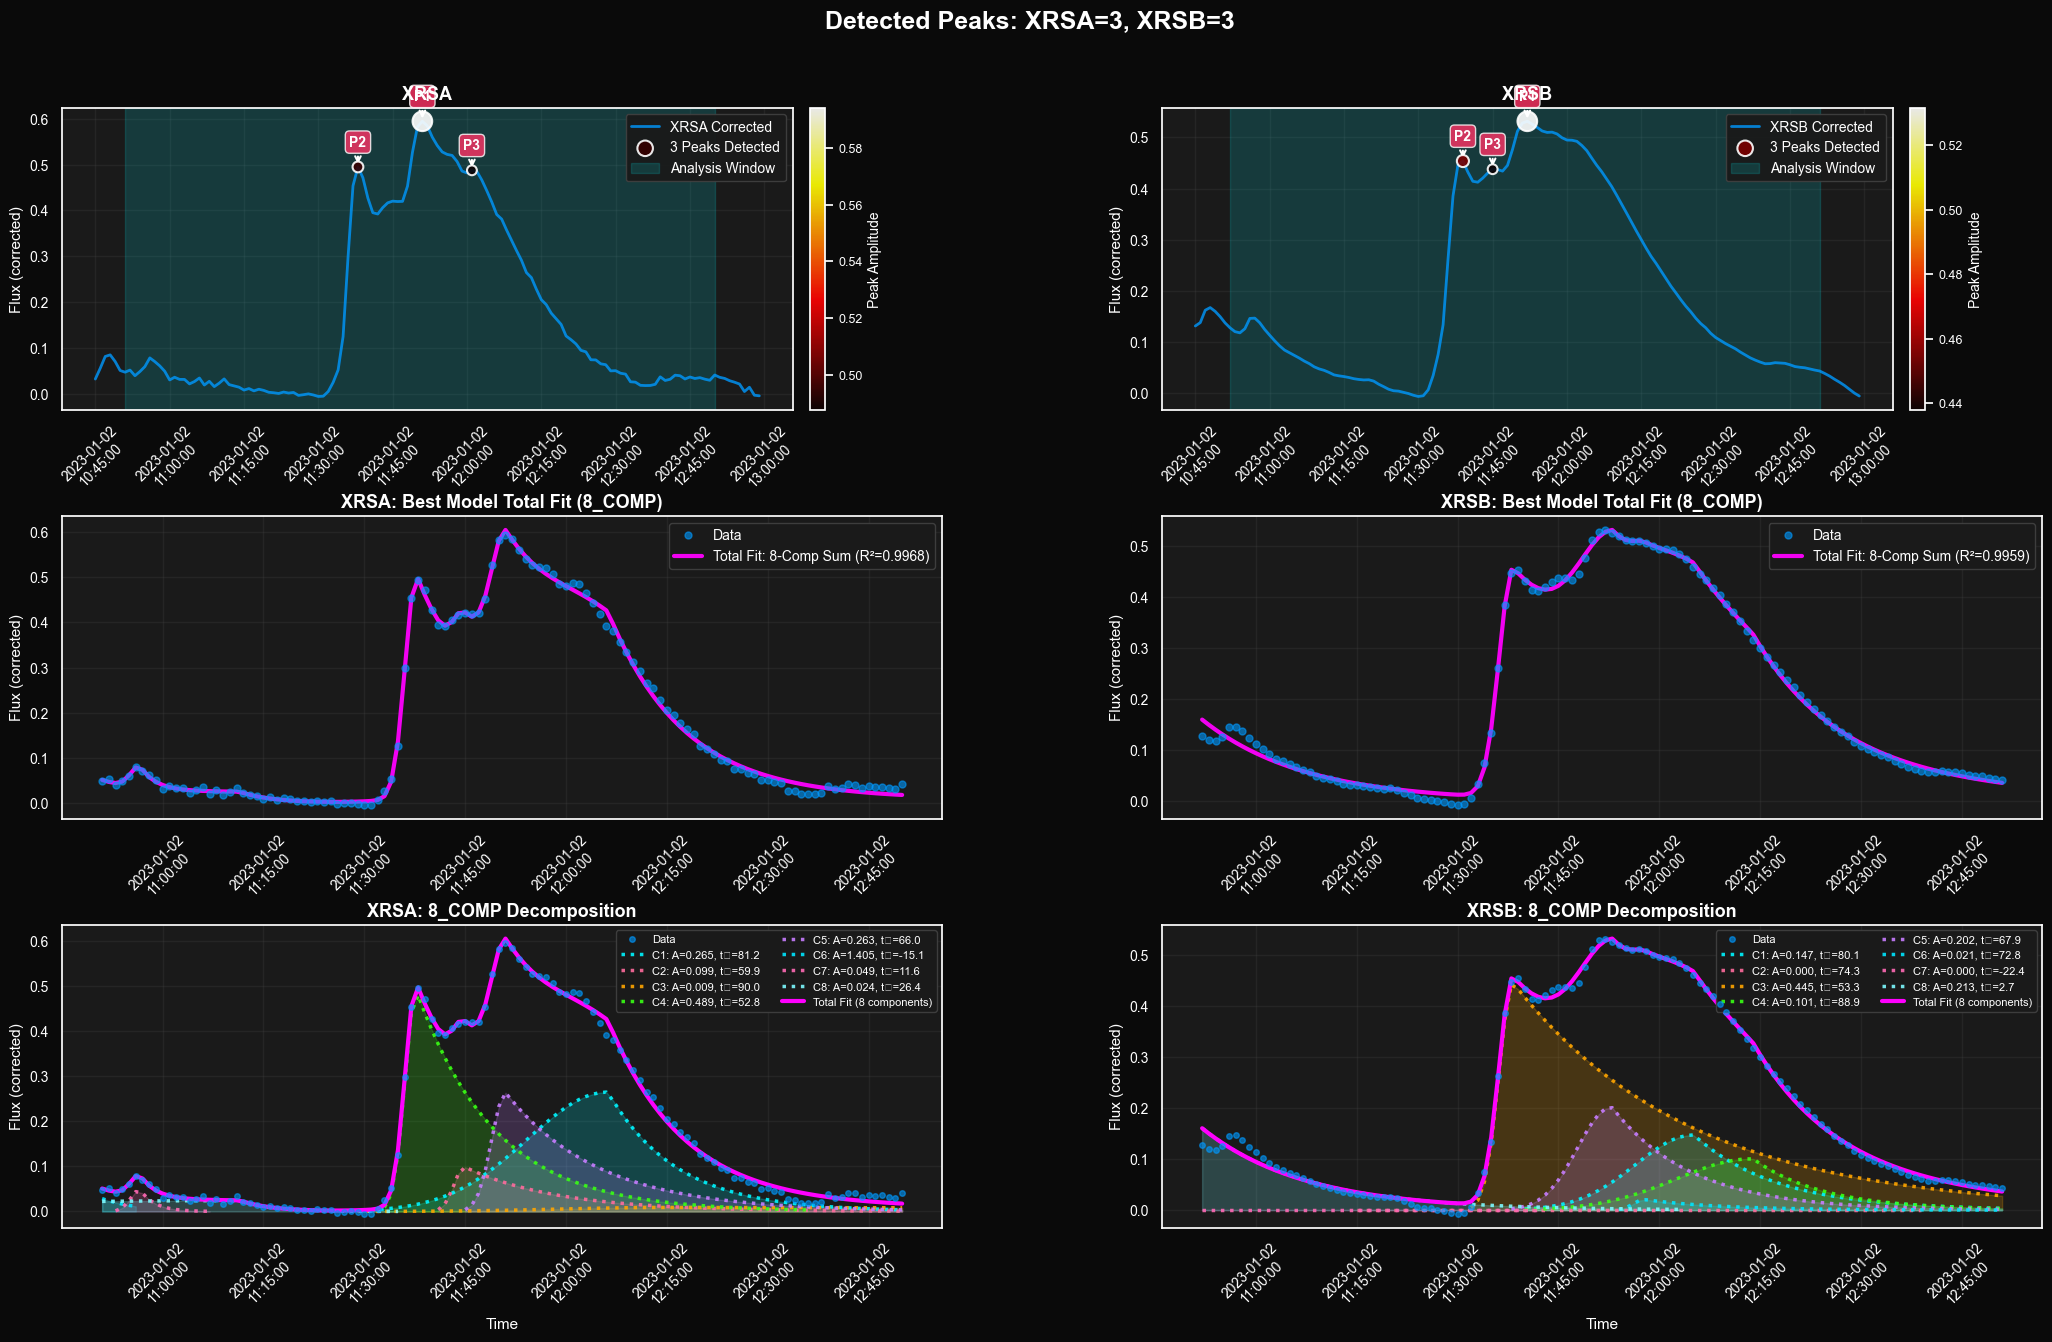

In [581]:
fig = plt.figure(figsize=(22, 14))
fig.patch.set_facecolor('#0a0a0a')
n_peaks_xrsa = len(analysis_results.get('xrsa', {}).get('all_peaks', []))
n_peaks_xrsb = len(analysis_results.get('xrsb', {}).get('all_peaks', []))
fig.suptitle(f'Detected Peaks: XRSA={n_peaks_xrsa}, XRSB={n_peaks_xrsb}', fontsize=18, fontweight='bold', color='white', y=0.95)
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.25, left=0.06, right=0.96, top=0.88, bottom=0.08)

def setup_ax(ax, title, ylabel='', xlabel=''):
    ax.set_facecolor(VIZ_COLORS['enhanced']['background'])
    ax.set_title(title, fontsize=13, fontweight='bold', color='white')
    if ylabel: ax.set_ylabel(ylabel, fontsize=11, color='white')
    if xlabel: ax.set_xlabel(xlabel, fontsize=11, color='white')
    ax.grid(True, alpha=0.3, color=VIZ_COLORS['enhanced']['grid'])
    ax.tick_params(axis='both', colors='white', labelsize=10)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M:%S'))
    ax.tick_params(axis='x', rotation=45)

def add_legend(ax):
    legend = ax.legend(fontsize=10, framealpha=0.95, loc='upper right')
    legend.get_frame().set_facecolor('#1a1a1a')
    legend.get_frame().set_edgecolor('#404040')
    for text in legend.get_texts(): text.set_color('white')

# ROW 1: FULL SIGNAL WITH ALL PEAKS
for i, channel in enumerate(['xrsa', 'xrsb']):
    if channel not in analysis_results: continue
    ax = fig.add_subplot(gs[0, i])
    setup_ax(ax, f'{channel.upper()}', 'Flux (corrected)')
    res = analysis_results[channel]
    ax.plot(res['full_time_datetime'], res['full_data'], color=VIZ_COLORS['enhanced']['data'], linewidth=2, alpha=0.8, label=f'{channel.upper()} Corrected')
    peaks = res['all_peaks']
    if peaks.size > 0:
        amps = res['all_peak_amplitudes']
        sizes = 50 + 150 * (amps - amps.min()) / (amps.max() - amps.min() + 1e-10)
        scatter = ax.scatter(res['full_time_datetime'][peaks], res['full_data'][peaks], c=amps, cmap='hot', s=sizes, edgecolors='white', linewidths=1.5, label=f'{len(peaks)} Peaks Detected', zorder=5, alpha=0.9)
        cbar = plt.colorbar(scatter, ax=ax, pad=0.02)
        cbar.set_label('Peak Amplitude', color='white', fontsize=10)
        cbar.ax.tick_params(colors='white', labelsize=9)
        for j, idx in enumerate(np.argsort(amps)[::-1][:3]):
            peak_pos = peaks[idx]
            ax.annotate(f'P{j+1}', xy=(res['full_time_datetime'][peak_pos], res['full_data'][peak_pos]), xytext=(0, 15), textcoords='offset points', ha='center', fontsize=10, fontweight='bold', color='white', bbox=dict(boxstyle='round,pad=0.3', facecolor=VIZ_COLORS['enhanced']['peak_marker'], alpha=0.8), arrowprops=dict(arrowstyle='->', color='white', lw=1.5))
    peak_times = res['peak_time_datetime']
    ax.axvspan(peak_times[0], peak_times[-1], alpha=0.15, color=VIZ_COLORS['enhanced']['comp_colors'][0], label='Analysis Window')
    add_legend(ax)

# ROW 2: BEST MODEL FIT
for i, channel in enumerate(['xrsa', 'xrsb']):
    if channel not in analysis_results or 'best_model' not in analysis_results[channel]: continue
    ax = fig.add_subplot(gs[1, i])
    setup_ax(ax, f'{channel.upper()}: Best Model Total Fit ({analysis_results[channel]["best_model"].upper()})', 'Flux (corrected)')
    res = analysis_results[channel]
    best_result = res['fitting_results'][res['best_model']]
    ax.plot(res['peak_time_datetime'], res['peak_data'], 'o', color=VIZ_COLORS['enhanced']['data'], markersize=5, alpha=0.6, label='Data', zorder=5)
    ax.plot(res['peak_time_datetime'], visualization_data[channel]['total_fit_row2'], '-', color=VIZ_COLORS['enhanced']['total_fit'], linewidth=3, alpha=0.95, label=f'Total Fit: {best_result["n_components"]}-Comp Sum (R²={best_result["r2"]:.4f})', zorder=4)
    add_legend(ax)

# ROW 3: COMPONENT DECOMPOSITION
for i, channel in enumerate(['xrsa', 'xrsb']):
    if channel not in analysis_results or 'best_model' not in analysis_results[channel]: continue
    ax = fig.add_subplot(gs[2, i])
    setup_ax(ax, f'{channel.upper()}: {analysis_results[channel]["best_model"].upper()} Decomposition', 'Flux (corrected)', 'Time')
    res = analysis_results[channel]
    viz_data = visualization_data[channel]
    n_comp = res['fitting_results'][res['best_model']]['n_components']
    n_merged = viz_data['n_merged']
    print(f"\n   {channel.upper()}: Visualizing {n_comp} components" + (f" ({viz_data['original_n']} → {n_comp}, {n_merged} merged)" if n_merged > 0 else ""))
    ax.plot(res['peak_time_datetime'], res['peak_data'], 'o', color=VIZ_COLORS['enhanced']['data'], markersize=4, alpha=0.6, label='Data', zorder=6)
    comp_colors = get_component_colors(n_comp)
    for comp in viz_data['components']:
        color = comp_colors[comp['idx'] % len(comp_colors)]
        label = f'C{comp["idx"]+1}: A={comp["A"]:.3f}, t₀={comp["t0"]:.1f}'
        ax.plot(comp['visible_time_datetime'], comp['visible_values'], ':', color=color, linewidth=2.5, alpha=0.9, label=label, zorder=3)
        ax.fill_between(comp['visible_time_datetime'], 0, comp['visible_values'], alpha=0.2, color=color, zorder=2)
    ax.plot(res['peak_time_datetime'], viz_data['total_fit_row3'], '-', color=VIZ_COLORS['enhanced']['total_fit'], linewidth=3, label=f'Total Fit ({n_comp} components)', zorder=4)
    if n_merged > 0: ax.set_title(ax.get_title() + f' ({n_comp} physical, {n_merged} merged)', fontsize=13, fontweight='bold', color='white')
    legend = ax.legend(fontsize=8, framealpha=0.95, loc='upper right', ncol=2)
    legend.get_frame().set_facecolor('#1a1a1a')
    legend.get_frame().set_edgecolor('#404040')
    for text in legend.get_texts(): text.set_color('white')

plt.tight_layout()
plt.show()

# Now , our algorihme is ready , lets run for full dataset .

### Now for Full Dataset Analysis (to test 7 Days) change the `end_datetime_full`

In [582]:
# Define the time range for 7 days
start_datetime_full = '2023-01-01 00:00:00'  # Start date
end_datetime_full = '2023-01-08 00:00:00'    # 7 days later
# Filter data for 7 days
df_full = df_clean[(df_clean['datetime'] >= start_datetime_full) & (df_clean['datetime'] <= end_datetime_full)].copy()
df_full_clean=df_full.dropna()
print(f"Full dataset shape: {df_full.shape}")
print(f"Time range: {df_full['datetime'].min()} to {df_full['datetime'].max()}")
print(f"Total duration: {(df_full['datetime'].max() - df_full['datetime'].min()).days} days")
print(f"Total data points: {len(df_full)}")

Full dataset shape: (10081, 3)
Time range: 2023-01-01 00:00:00 to 2023-01-08 00:00:00
Total duration: 7 days
Total data points: 10081


# Converting to log + Baseline Correction

In [583]:
# Prepare full dataset for analysis (same as previous preprocessing)
time_datetime_full = df_full_clean['datetime'].values
xrsa_flux_full = df_full_clean['xrsa_flux'].values
xrsb_flux_full = df_full_clean['xrsb_flux'].values
# Create numeric time array for mathematical operations
time_numeric_full = np.arange(len(time_datetime_full), dtype=np.float64)
# Calculate log values
epsilon = 1e-12
log_xrsa_full = np.log10(np.maximum(xrsa_flux_full, epsilon)) 
log_xrsb_full = np.log10(np.maximum(xrsb_flux_full, epsilon))
print(f"Time range: {time_datetime_full.min()} to {time_datetime_full.max()}")
print(f"Numeric time range: {time_numeric_full.min():.1f} to {time_numeric_full.max():.1f}")

# Apply baseline correction
baseline_fitter_full = Baseline(time_numeric_full)
xrsa_baseline_full, _ = baseline_fitter_full.asls(log_xrsa_full, lam=1e6, p=0.01)
xrsb_baseline_full, _ = baseline_fitter_full.asls(log_xrsb_full, lam=1e6, p=0.01)
xrsa_corrected_full = log_xrsa_full - xrsa_baseline_full
xrsb_corrected_full = log_xrsb_full - xrsb_baseline_full

Time range: 2023-01-01T00:00:00.000000000 to 2023-01-08T00:00:00.000000000
Numeric time range: 0.0 to 10080.0


## 1. GOES Flare Classification (`classify_flare`)

**GOES Classification Scale:**
- **X-class**: $F_{peak} \geq 10^{-4}$ W/m² — Major flares with significant impacts on Earth
- **M-class**: $10^{-5} \leq F_{peak} < 10^{-4}$ W/m² — Medium flares, can cause brief radio blackouts
- **C-class**: $10^{-6} \leq F_{peak} < 10^{-5}$ W/m² — Small flares with minimal effects
- **B-class**: $10^{-7} \leq F_{peak} < 10^{-6}$ W/m² — Very small flares
- **A-class**: $F_{peak} < 10^{-7}$ W/m² — Background fluctuations

**Mathematical Implementation:**
Simple threshold-based classification using peak irradiance measured at 1 AU (Sun-Earth distance).

In [584]:
# FLARE CLASSIFICATION FUNCTION based on GOES standards
def classify_flare(peak_irradiance_wm2):
    if peak_irradiance_wm2 >= 1.0e-4:
        return 'X'
    elif peak_irradiance_wm2 >= 1.0e-5:
        return 'M'
    elif peak_irradiance_wm2 >= 1.0e-6:
        return 'C'
    elif peak_irradiance_wm2 >= 1.0e-7:
        return 'B'
    else:
        return 'A'

## 2. Flare Energy Calculation (`calculate_flare_energy`)


**Mathematical Formula:**
$$E_{total} = 4\pi d^2 \times \int F(t) \, dt$$

Where:
- $F(t)$ = X-ray flux at Earth [W/m²]
- $d$ = Sun-Earth distance = $1.496 \times 10^{11}$ m (1 AU)
- $4\pi d^2$ = Surface area of sphere at Earth's orbit (accounts for isotropic radiation)

**Integral Approximation:**
Since we have an asymmetric flare model (Gaussian rise + exponential decay), we approximate:

$$\int F(t) \, dt \approx F_{peak} \times \Delta t \times \alpha$$

where:
- $\Delta t$ = flare duration [seconds]
- $\alpha \approx 0.5$ (effective filling factor for asymmetric profile)
- This assumes average flux = 50% of peak flux

**Energy Conversion:**
Result is converted from Joules to ergs: $1 \text{ J} = 10^7 \text{ erg}$

In [585]:
def calculate_flare_energy(peak_irradiance_wm2, duration_seconds, sun_earth_distance_au=1.0):
   # Sun-Earth distance in meters (1 AU = 1.496×10¹¹ m)
    d_meters = sun_earth_distance_au * 1.496e11  # meters
    # For asymmetric flare: integral ≈ F_peak × duration × 0.5
    flux_integral_SI = peak_irradiance_wm2 * duration_seconds * 0.5  # [W·m⁻²·s] = [J·m⁻²]
    energy_joules = 4 * np.pi * (d_meters ** 2) * flux_integral_SI
    # Convert Joules to ergs (1 J = 10⁷ erg)
    energy_ergs = energy_joules * 1e7
    return energy_ergs

## 3. Flare Duration Calculation (`calculate_flare_duration`)
1. Locate peak time $t_0$ where $F(t)$ is maximum
2. Calculate threshold: $F_{threshold} = 0.01 \times F_{peak}$ (1% of peak)
3. Find temporal boundaries:
   - $t_{start}$: earliest time where $F(t) > F_{threshold}$
   - $t_{end}$: latest time where $F(t) > F_{threshold}$
4. Duration: $\Delta t = t_{end} - t_{start}$

**Mathematical Representation:**
$$\text{Duration} = \max\{t : F(t) > 0.01 \cdot F_{peak}\} - \min\{t : F(t) > 0.01 \cdot F_{peak}\}$$

- The 1% threshold captures the significant emission phase while excluding low-level background

**Returns:**
- `duration_min`: Duration in minutes (time above threshold)
- `start_time`: Numeric time when flare begins (crosses threshold on rise)
- `end_time`: Numeric time when flare ends (crosses threshold on decay)

In [586]:
def calculate_flare_duration(t, data, t0, threshold_fraction=0.01):
    peak_idx = np.argmin(np.abs(t - t0)) 
    peak_val = data[peak_idx]
    threshold = threshold_fraction * peak_val 
    above_threshold = data > threshold
    if not np.any(above_threshold):
        return 0.0, t0, t0
    
    # Find start and end indices
    indices = np.where(above_threshold)[0]
    start_idx = indices[0]
    end_idx = indices[-1]
    start_time = t[start_idx]
    end_time = t[end_idx]
    duration_min = end_time - start_time
    return duration_min, start_time, end_time

# Main Algorithm: Multi-Component Flare Detection


In [587]:
# Main processing function: detect and fit flares with asymmetric model
def process_full_dataset_events_fast(df, flux_corrected, baseline_full, channel='xrsb', window_size=analysis_window, overlap=0,prominence_factor=XRSB_PROMINENCE_FACTOR, min_peak_distance=XRSB_MIN_PEAK_DISTANCE,max_components_to_try=3):
    
    # Initialize time and flux arrays (use pre-processed baseline-corrected flux)
    time_full = np.arange(len(df), dtype=np.float64)
    time_datetime_full = df['datetime'].values
    flux_full = df['xrsa_flux' if channel == 'xrsa_flux' else 'xrsb_flux'].values
    
    # Use the provided baseline-corrected flux (already log-transformed and baseline-corrected)
    flux_corrected = np.maximum(flux_corrected, 0)
    
    # Setup sliding window processing
    all_events, event_id = [], 0
    step_size = window_size - overlap
    num_windows = int((len(time_full) - window_size) / step_size) + 1
    processed_peaks = {}  # Duplicate detection: time_key -> peak_time
    
    print(f"\nProcessing {num_windows} windows for {channel.upper()}")
    print(f"Window: {window_size}min, Overlap: {overlap}min, Max components: {max_components_to_try}")
    
    # Time tracking
    import time as time_module
    start_time = time_module.time()
    format_time = lambda s: f"{s:.0f}s" if s < 60 else f"{s/60:.1f}min" if s < 3600 else f"{s/3600:.1f}hr"
    
    # Process each window
    for w_idx in range(num_windows):
        start_idx, end_idx = w_idx * step_size, min(w_idx * step_size + window_size, len(time_full))
        if end_idx - start_idx < 50:  # Skip small windows
            continue
        
        # Extract window and detect peaks
        time_window, flux_window = time_full[start_idx:end_idx], flux_corrected[start_idx:end_idx]
        peaks, _ = find_significant_peaks(flux_window, time_window, prominence_factor, min_peak_distance)
        
        if len(peaks) == 0:
            continue
        
        # Process each detected peak
        for peak_idx in peaks:
            peak_time_numeric = time_window[peak_idx]
            peak_time_datetime = time_datetime_full[start_idx + peak_idx]
            
            # Skip duplicates (round to nearest 5 min)
            time_key = round(peak_time_numeric / 5.0) * 5.0
            if time_key in processed_peaks:
                continue
            processed_peaks[time_key] = peak_time_numeric
            
            # Extract fitting window (±30 points around peak)
            fit_start, fit_end = max(0, peak_idx - 30), min(len(flux_window), peak_idx + 30)
            t_fit, y_fit = time_window[fit_start:fit_end], flux_window[fit_start:fit_end]
            
            if len(t_fit) < 10:
                continue
            
            # Fit with 1 to N components, keep best
            best_fit_result, best_r2 = None, -np.inf
            for n_comp in range(1, max_components_to_try + 1):
                try:
                    params, _, r2, fit, aic, bic = fit_asymmetric_robust(t_fit, y_fit, n_comp, 'global')
                    if params is not None and r2 > max(0.3, best_r2):
                        best_r2, best_fit_result = r2, {
                            'params': params, 'n_components': n_comp, 'r2': r2,
                            'aic': aic, 'bic': bic, 't_fit': t_fit, 'y_fit': y_fit, 'y_pred': fit
                        }
                except:
                    continue
            
            if best_fit_result is None:
                continue
            
            event_id += 1
            
            # Identify and merge unphysical components (slow rise, fast decay)
            raw_comps = [{'idx': i, 'A': best_fit_result['params'][i*4], 't0': best_fit_result['params'][i*4+1],
                         'sigma_r': best_fit_result['params'][i*4+2], 'tau_d': best_fit_result['params'][i*4+3],
                         'is_unphysical': best_fit_result['params'][i*4+2] > best_fit_result['params'][i*4+3] * 2.0}
                        for i in range(best_fit_result['n_components'])]
            
            # Merge unphysical into nearest physical neighbor
            skip_indices, amplitude_boosts = set(), {}
            for comp in [c for c in raw_comps if c['is_unphysical']]:
                physical = [c for c in raw_comps if c['idx'] != comp['idx'] and not c['is_unphysical']]
                if physical:
                    nearest = min(physical, key=lambda c: abs(c['t0'] - comp['t0']))
                    skip_indices.add(comp['idx'])
                    amplitude_boosts[nearest['idx']] = amplitude_boosts.get(nearest['idx'], 0) + comp['A'] * 0.75
            
            # Build final physical components with merged amplitudes
            components = []
            for comp_idx in range(best_fit_result['n_components']):
                if comp_idx in skip_indices:
                    continue
                
                # Extract parameters and apply amplitude boost
                A, t0 = best_fit_result['params'][comp_idx*4], best_fit_result['params'][comp_idx*4+1]
                sigma_r, tau_d = best_fit_result['params'][comp_idx*4+2], best_fit_result['params'][comp_idx*4+3]
                A += amplitude_boosts.get(comp_idx, 0)
                
                # Convert baseline-corrected amplitude back to W/m²
                t0_idx = np.argmin(np.abs(time_full - t0))
                peak_irradiance_wm2 = 10 ** (A + baseline_full[t0_idx])
                
                # Calculate flare timing and energy
                component_flux = asymmetric_flare(t_fit, A, t0, sigma_r, tau_d)
                duration_min, start_time, end_time = calculate_flare_duration(t_fit, component_flux, t0, 0.1)
                
                components.append({
                    'component_id': comp_idx + 1,
                    'amplitude': A,
                    't0_numeric': t0,
                    't0_datetime': pd.to_datetime(time_datetime_full[int(np.clip(t0, 0, len(time_datetime_full)-1))]),
                    'flare_start_datetime': pd.to_datetime(time_datetime_full[np.argmin(np.abs(time_full - start_time))]),
                    'flare_end_datetime': pd.to_datetime(time_datetime_full[np.argmin(np.abs(time_full - end_time))]),
                    'sigma_rise': sigma_r,
                    'tau_decay': tau_d,
                    'peak_irradiance_wm2': peak_irradiance_wm2,
                    'duration_minutes': duration_min,
                    'duration_seconds': duration_min * 60,
                    'rise_fwhm_minutes': 2.355 * sigma_r,
                    'energy_ergs': calculate_flare_energy(peak_irradiance_wm2, duration_min * 60),
                    'flare_class': classify_flare(peak_irradiance_wm2)
                })
            
            all_events.append({
                'event_id': event_id,
                'channel': channel,
                'peak_time_numeric': peak_time_numeric,
                'peak_time_datetime': pd.to_datetime(peak_time_datetime),
                'n_components': len(components),
                'original_n_components': best_fit_result['n_components'],
                'n_merged': len(skip_indices),
                'r2_score': best_r2,
                'components': components,
                'window_index': w_idx
            })
    
    total_time = time_module.time() - start_time
    print(f"\n Completed in {format_time(total_time)}! Found {len(all_events)} events in {channel.upper()}")
    return all_events


# Algorithme Running 

In [588]:
import time as time_module
overall_start = time_module.time()

channels = [
    ('XRSB (1-8 Å)', 'xrsb_flux', xrsb_corrected_full, xrsb_baseline_full, XRSB_PROMINENCE_FACTOR, XRSB_MIN_PEAK_DISTANCE),
    ('XRSA (0.5-4 Å)', 'xrsa_flux', xrsa_corrected_full, xrsa_baseline_full, XRSA_PROMINENCE_FACTOR, XRSA_MIN_PEAK_DISTANCE)
]

all_events = {}
for name, channel, flux, baseline, prominence, min_dist in channels:
    print(f"\nPROCESSING {name}")
    start = time_module.time()
    events = process_full_dataset_events_fast(df_full_clean, flux, baseline, channel, analysis_window, 0, prominence, min_dist, 3)
    elapsed = time_module.time() - start
    all_events[channel] = events
    print(f"Complete in {elapsed/60:.1f}min | Events: {len(events)} | Components: {sum(len(e['components']) for e in events)}")

xrsb_events, xrsa_events = all_events['xrsb_flux'], all_events['xrsa_flux']
total_elapsed = time_module.time() - overall_start
total_comps = sum(len(e['components']) for e in xrsb_events + xrsa_events)
print(f"TOTAL: {total_elapsed/60:.1f}min ({total_elapsed/3600:.2f}hr) | Events: {len(xrsb_events)+len(xrsa_events)} | Components: {total_comps}")



PROCESSING XRSB (1-8 Å)

Processing 84 windows for XRSB_FLUX
Window: 120min, Overlap: 0min, Max components: 3
   Peak heights: [0.07199049 0.19667006 0.10046816 0.0806489  0.08267736 0.10342979
 0.12733269 0.13589287]
   Peak heights: [0.17000466 0.09420016]
   Peak heights: [0.17000466 0.09420016]
   Peak heights: [0.17000466 0.09420016 0.08396587]
   Peak heights: [0.17000466 0.09420016 0.08396587]
   Peak heights: [0.17278319 0.09697869 0.0867444 ]
   Peak heights: [0.17278319 0.09697869 0.0867444 ]
   Peak heights: [0.12426351 0.13239275]
   Peak heights: [0.12426351 0.13239275]
   Peak heights: [0.12426351 0.13239275]
   Peak heights: [0.12426351 0.13239275]
   Peak heights: [0.49022055 0.21535349]
   Peak heights: [0.44614992]
   Peak heights: [0.44614992]
   Peak heights: [0.16692448 0.15442801 0.10766983]
   Peak heights: [0.15902775 0.14409277]
   Peak heights: [0.15902775 0.14409277]
   Peak heights: [0.10563964 0.09070465]
   Peak heights: [0.10563964 0.09070465]
   Peak he

# Convert to dict 

In [589]:
# Create simplified flare dictionary
from collections import OrderedDict
def create_flare_dict(events, channel_name, baseline_full, time_full, time_datetime_full):
    """Convert events to simple flat list of flares with essential fields"""
    flares = []
    flare_num = 1
    
    for event in events:
        for comp in event['components']:
            # Calculate time series
            start_idx = max(0, np.argmin(np.abs(time_full - (comp['t0_numeric'] - comp['sigma_rise'] * 5))))
            end_idx = min(len(time_full), np.argmin(np.abs(time_full - (comp['t0_numeric'] + comp['tau_decay'] * 10))))
            t_series = time_full[start_idx:end_idx]
            flux_log = asymmetric_flare(t_series, comp['amplitude'], comp['t0_numeric'], comp['sigma_rise'], comp['tau_decay'])
            irradiance = (10 ** (flux_log + baseline_full[start_idx:end_idx])).astype(np.float64)
            
            # Get start/end indices from actual data
            start_time_idx = np.argmin(np.abs(time_full - comp['t0_numeric'] + comp['sigma_rise'] * 3))
            end_time_idx = np.argmin(np.abs(time_full - comp['t0_numeric'] - comp['tau_decay'] * 5))
            
            flares.append(OrderedDict({
                'flare_number': flare_num,
                'channel': channel_name,
                'start_time_datetime': comp['flare_start_datetime'],
                'start_time_minutes': float(time_full[max(0, start_time_idx)]),
                'end_time_datetime': comp['flare_end_datetime'],
                'end_time_minutes': float(time_full[min(len(time_full)-1, end_time_idx)]),
                'duration_minutes': float(comp['duration_minutes']),
                'irradiance_wm2': irradiance.tolist(),
                'amplitude_wm2': float(comp['peak_irradiance_wm2']),
                'sigma_rise': float(comp['sigma_rise']),
                'tau_decay': float(comp['tau_decay']),
                'flare_class': comp['flare_class'],
                'energy_ergs': float(comp['energy_ergs'])
            }))
            flare_num += 1
    
    return flares

# Create combined dictionary
flare_data_dict = {
    'xrsb': create_flare_dict(xrsb_events, 'XRSB', xrsb_baseline_full, time_numeric_full, time_datetime_full),
    'xrsa': create_flare_dict(xrsa_events, 'XRSA', xrsa_baseline_full, time_numeric_full, time_datetime_full)
}

total_flares = len(flare_data_dict['xrsb']) + len(flare_data_dict['xrsa'])
print(f" Simplified flare dictionary: {len(flare_data_dict['xrsb'])} XRSB + {len(flare_data_dict['xrsa'])} XRSA flares ({total_flares} total)")
print(f"  Access: flare_data_dict['xrsb'][flare_idx]['irradiance_wm2']")


 Simplified flare dictionary: 600 XRSB + 1004 XRSA flares (1604 total)
  Access: flare_data_dict['xrsb'][flare_idx]['irradiance_wm2']


# How To access this dict ?

In [590]:
# Example: Access irradiance from flare_data_dict
# Get irradiance array for first XRSB flare
irradiance = flare_data_dict['xrsb'][0]['irradiance_wm2']
print(f"Irradiance array length: {len(irradiance)}")
print(f"First 5 values: {irradiance[:5]}")
print(f"Max irradiance: {max(irradiance):.2e} W/m²")

# Loop through all XRSB flares and get their irradiance
for i, flare in enumerate(flare_data_dict['xrsb'][:3]):  # First 3 flares
    irr = flare['irradiance_wm2']
    print(f"Flare {i+1}: {flare['flare_class']}-class, irradiance max = {max(irr):.2e} W/m²")

Irradiance array length: 25
First 5 values: [1.116108939488344e-06, 1.118238869588641e-06, 1.155931729381462e-06, 1.4195277414812279e-06, 1.5800441924028287e-06]
Max irradiance: 1.58e-06 W/m²
Flare 1: C-class, irradiance max = 1.58e-06 W/m²
Flare 2: C-class, irradiance max = 1.36e-06 W/m²
Flare 3: C-class, irradiance max = 1.81e-06 W/m²


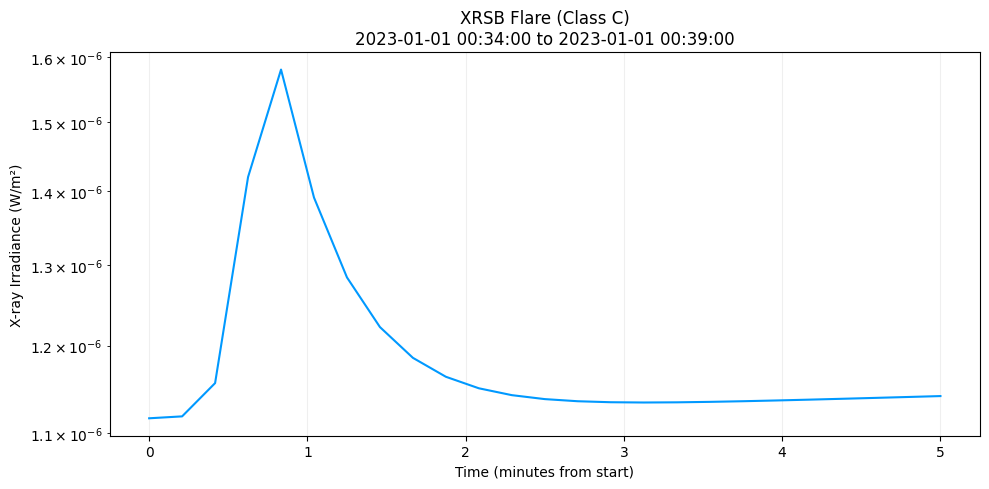

In [611]:
import matplotlib.pyplot as plt
import numpy as np
first_key = list(flare_data_dict.keys())[0] 
first_flare = flare_data_dict[first_key][0]  
start_time = first_flare['start_time_datetime']
end_time = first_flare['end_time_datetime']
irradiance_values = np.array(first_flare['irradiance_wm2'])

duration_minutes = first_flare['duration_minutes']
time_values = np.linspace(0, duration_minutes, len(irradiance_values))
plt.style.use('default')
plt.figure(figsize=(10, 5), facecolor='white')
plt.plot(time_values, irradiance_values, linewidth=1.5, color='#0099FF')
plt.xlabel('Time (minutes from start)')
plt.ylabel('X-ray Irradiance (W/m²)')
plt.title(f'{first_flare["channel"]} Flare (Class {first_flare["flare_class"]})\n{start_time} to {end_time}')
plt.grid(True, alpha=0.2)
plt.yscale('log')
plt.tight_layout()
plt.show()


In [599]:
print(flare[0]['end_time_datetime'])

2023-01-01 00:39:00
